In [ ]:
from google.colab import drive
import os
import shutil

# Unmount drive if already mounted and clear the mountpoint
if os.path.exists('/content/drive'):
    try:
        drive.flush_and_unmount()
        # It might take a moment for the unmount to complete,
        # but often clearing the directory is sufficient.
    except ValueError:
        # Drive was not mounted, no need to unmount
        pass

    # Clear the mountpoint directory
    if os.path.exists('/content/drive') and os.path.isdir('/content/drive'):
        for item in os.listdir('/content/drive'):
            item_path = os.path.join('/content/drive', item)
            try:
                if os.path.isfile(item_path) or os.path.islink(item_path):
                    os.unlink(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
            except Exception as e:
                print(f"Error removing {item_path}: {e}")


drive.mount('/content/drive', force_remount=True)

print("✅ Drive mounted.")
print("Drive contents at root:")
for f in os.listdir("/content/drive"):
    print(" -", f)

# verify main project folder exists
proj = "/content/drive/MyDrive/oasis_project"
print("\nProject folder exists?", os.path.exists(proj))
if os.path.exists(proj):
    print("Contents of oasis_project:")
    for f in os.listdir(proj):
        print("   ", f)

Mounted at /content/drive
✅ Drive mounted.
Drive contents at root:
 - MyDrive
 - .shortcut-targets-by-id
 - .Trash-0
 - .Encrypted

Project folder exists? True
Contents of oasis_project:
    notebooks
    data
    outputs
    logs
    oasis2_graph_dataset.pt


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.4 MB/s eta 0:00:00


In [ ]:
# Cell 2: Utility functions
import matplotlib
import torch # Import torch here to define device
import numpy as np # Import numpy here for np.nan

def compute_graph_embeddings(graphs, encoder, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), batch_mode=False):
    """
    Returns:
      embs: (N_graphs, emb_dim) numpy array
      labels: list of labels (float)
      ids: list of subject ids
    """
    encoder.eval()
    embs = []
    labels = []
    ids = []
    with torch.no_grad():
        for g in graphs:
            # ensure graph is on device and has batch
            if hasattr(g, "batch") and g.batch is None:
                g.batch = torch.zeros(g.x.size(0), dtype=torch.long)
            else:
                g.batch = torch.zeros(g.x.size(0), dtype=torch.long)
            # move to device
            g = g.to(device)
            e = encoder(g)  # encoder should return graph-level embedding (B x D) or (D,)
            # allow single-dim squeezes
            if isinstance(e, torch.Tensor):
                e = e.cpu().numpy().squeeze()
            embs.append(e)
            labels.append(float(g.y.item()) if hasattr(g, "y") else np.nan)
            ids.append(getattr(g, "subject_id", "NA"))
    embs = np.vstack(embs)
    return embs, labels, ids

def save_fig(fig, name, dpi=150):
    path = os.path.join(FIG_DIR, name)
    fig.savefig(path, dpi=dpi, bbox_inches='tight')
    print("Saved:", path)

In [ ]:
#12/10

In [ ]:
import torch, os
from pathlib import Path
path = "/content/drive/MyDrive/oasis_project/outputs/models/best_graphsage.pt"
assert os.path.exists(path), f"File not found: {path}"

loaded = torch.load(path, map_location='cpu')
print("Loaded object type:", type(loaded))

# Case A: full nn.Module saved
import torch.nn as nn
if isinstance(loaded, nn.Module):
    model = loaded.to('cuda' if torch.cuda.is_available() else 'cpu')
    globals()['model'] = model
    globals()['encoder'] = model
    print("Assigned loaded nn.Module to `model` and `encoder`. model device:", next(model.parameters()).device)
else:
    # Save for inspection and print summary
    globals()['loaded_checkpoint'] = loaded
    if isinstance(loaded, dict):
        print("Loaded dict keys():", list(loaded.keys())[:50])
        # If there's a state_dict nested
        if 'state_dict' in loaded:
            print("Found key 'state_dict' (likely a checkpoint).")
            sd = loaded['state_dict']
            # show some keys of the state_dict
            if isinstance(sd, dict):
                print("state_dict top keys (sample 20):", list(sd.keys())[:20])
        elif all(isinstance(v, torch.Tensor) for v in loaded.values()):
            print("This appears to be a raw state_dict (tensor dict). Sample keys:", list(loaded.keys())[:20])
    else:
        # unknown object: print repr (short)
        try:
            print("Loaded object repr (short):", repr(loaded)[:1000])
        except Exception:
            pass
    print("\nIf this is a state_dict, paste the printed top keys here and tell me whether you have the model class code in the notebook (yes/no).")


Loaded object type: <class 'collections.OrderedDict'>
Loaded dict keys(): ['conv1.lin_l.weight', 'conv1.lin_l.bias', 'conv1.lin_r.weight', 'conv2.lin_l.weight', 'conv2.lin_l.bias', 'conv2.lin_r.weight', 'lin.weight', 'lin.bias']
This appears to be a raw state_dict (tensor dict). Sample keys: ['conv1.lin_l.weight', 'conv1.lin_l.bias', 'conv1.lin_r.weight', 'conv2.lin_l.weight', 'conv2.lin_l.bias', 'conv2.lin_r.weight', 'lin.weight', 'lin.bias']

If this is a state_dict, paste the printed top keys here and tell me whether you have the model class code in the notebook (yes/no).


In [ ]:
# Try loading the most plausible GraphSAGE / model files (auto-inspect & either set model or save state_dict)
import torch, os, glob
import torch.nn as nn

candidates = [
    "/content/drive/MyDrive/oasis_project/outputs/models/best_graphsage_oasis2.pt",
    "/content/drive/MyDrive/oasis_project/outputs/models/best_graphsage.pt",
    "/content/drive/MyDrive/oasis_project/outputs/model_best_weighted.pt",
    "/content/drive/MyDrive/oasis_project/outputs/models/mlp_standardized_best.pt"
]
# only keep existing ones
candidates = [p for p in candidates if os.path.exists(p)]
print("Trying candidate files (in order):")
for p in candidates:
    print(" -", p)
if not candidates:
    raise FileNotFoundError("No candidate model files exist at the expected paths. Re-run search to reveal more.")

loaded_any = False
for path in candidates:
    print("\n=== Trying:", path)
    try:
        loaded = torch.load(path, map_location='cpu')
    except Exception as e:
        print("  torch.load failed for", path, ":", e)
        continue

    print("  -> loaded type:", type(loaded))
    # Case 1: full nn.Module object saved
    if isinstance(loaded, nn.Module):
        model = loaded.to('cuda' if torch.cuda.is_available() else 'cpu')
        globals()['model'] = model
        globals()['encoder'] = model
        print("  => Loaded full nn.Module and assigned to globals()['model'] and globals()['encoder'].")
        loaded_any = True
        break

    # Case 2: checkpoint dict
    if isinstance(loaded, dict):
        globals()['loaded_checkpoint'] = loaded
        print("  => saved checkpoint to globals()['loaded_checkpoint']. Keys:", list(loaded.keys())[:40])
        # If it contains 'state_dict' or similar, extract and show sample keys
        sd = None
        for k in ('state_dict', 'model_state_dict', 'model', 'net', 'sd'):
            if k in loaded:
                sd = loaded[k]
                print("     - Found key:", k, "-> likely state_dict or nested model.")
                break
        if sd is None:
            # maybe it's a raw state_dict
            if all(isinstance(v, torch.Tensor) for v in loaded.values()):
                sd = loaded
                print("     - The loaded dict appears to be a raw state_dict (tensor mapping).")
        if sd is not None:
            # show sample keys
            try:
                sample_keys = list(sd.keys())[:60]
                print("     - state_dict sample keys (up to 60):")
                for kk in sample_keys[:60]:
                    print("        ", kk)
                # store sd globally for later load into model class
                globals()['loaded_state_dict'] = sd
                # auto-clean module. prefix if present
                if any(k.startswith("module.") for k in sd.keys()):
                    from collections import OrderedDict
                    new_sd = OrderedDict()
                    for k,v in sd.items():
                        new_key = k.replace("module.", "", 1)
                        new_sd[new_key] = v
                    globals()['loaded_state_dict_clean'] = new_sd
                    print("     - detected 'module.' prefixes; created cleaned copy at globals()['loaded_state_dict_clean'].")
                else:
                    globals()['loaded_state_dict_clean'] = sd
                loaded_any = True
            except Exception as e:
                print("     - Could not inspect state_dict keys:", e)
        # done with this candidate (break if you want first match)
        break

    # Unknown object type: print repr shortened
    try:
        print("  -> repr:", repr(loaded)[:1000])
        globals()['loaded_checkpoint'] = loaded
        loaded_any = True
        break
    except Exception:
        continue

if not loaded_any:
    print("\nNo usable model or state_dict was loaded from candidates. You can run the full search and paste results.")
else:
    # If model set, print quick summary and test forward-shape on graphs[0] if available
    if 'model' in globals() and globals()['model'] is not None:
        print("\nFinal model type:", type(globals()['model']))
        try:
            mdev = next(globals()['model'].parameters()).device
            print("Model device (param):", mdev)
        except Exception:
            pass
        # optional quick forward test if graphs exists
        if 'graphs' in globals() and len(graphs) > 0:
            try:
                g = graphs[0]
                # ensure batch
                if not hasattr(g, 'batch') or g.batch is None:
                    g.batch = torch.zeros(getattr(g, 'num_nodes', g.x.size(0)), dtype=torch.long)
                globals()['model'].eval()
                with torch.no_grad():
                    try:
                        out = globals()['model'](g)
                    except Exception:
                        out = globals()['model'](g.x, g.edge_index, g.batch)
                print("Quick forward returned tensor shape:", out.shape if isinstance(out, torch.Tensor) else type(out))
            except Exception as e:
                print("Quick forward test failed:", e)

print("\nDone. If a state_dict was printed above, paste the top state_dict key names here and tell me whether you have the model class (GraphSAGE) code present in the notebook — then I'll give the exact instantiation + load_state_dict snippet to run.")



Trying candidate files (in order):
 - /content/drive/MyDrive/oasis_project/outputs/models/best_graphsage_oasis2.pt
 - /content/drive/MyDrive/oasis_project/outputs/models/best_graphsage.pt
 - /content/drive/MyDrive/oasis_project/outputs/model_best_weighted.pt
 - /content/drive/MyDrive/oasis_project/outputs/models/mlp_standardized_best.pt

=== Trying: /content/drive/MyDrive/oasis_project/outputs/models/best_graphsage_oasis2.pt
  -> loaded type: <class 'collections.OrderedDict'>
  => saved checkpoint to globals()['loaded_checkpoint']. Keys: ['conv1.lin_l.weight', 'conv1.lin_l.bias', 'conv1.lin_r.weight', 'conv2.lin_l.weight', 'conv2.lin_l.bias', 'conv2.lin_r.weight', 'lin.weight', 'lin.bias']
     - The loaded dict appears to be a raw state_dict (tensor mapping).
     - state_dict sample keys (up to 60):
         conv1.lin_l.weight
         conv1.lin_l.bias
         conv1.lin_r.weight
         conv2.lin_l.weight
         conv2.lin_l.bias
         conv2.lin_r.weight
         lin.weight
   

In [ ]:
# Auto-instantiate GraphSAGE-like model from loaded_state_dict_clean and load weights
import torch, torch.nn as nn, torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the cleaned state_dict is present
if 'loaded_state_dict_clean' not in globals():
    raise RuntimeError("globals()['loaded_state_dict_clean'] not found. Run the previous inspection cell to populate it.")

sd = globals()['loaded_state_dict_clean']
print("Top keys from state_dict (sample):", list(sd.keys())[:20])

# Infer dimensions from state_dict shapes (best-effort)
def tensor_shape(k):
    t = sd[k]
    return tuple(t.shape)

# required keys (based on printed state_dict):
required_keys = ['conv1.lin_l.weight', 'conv2.lin_l.weight', 'lin.weight']
for k in required_keys:
    if k not in sd:
        raise KeyError(f"Expected key '{k}' in state_dict but not found. Keys available: {list(sd.keys())[:40]}")

conv1_w_shape = tensor_shape('conv1.lin_l.weight')  # (hidden, in_channels)
conv2_w_shape = tensor_shape('conv2.lin_l.weight')  # (hidden2, hidden)
lin_w_shape   = tensor_shape('lin.weight')          # (out_dim, hidden_pool) - often (out_dim, hidden)

in_channels = conv1_w_shape[1]
hidden_from_conv1 = conv1_w_shape[0]
hidden_from_conv2 = conv2_w_shape[0]
# pick hidden as the conv1 out dim; ensure conv2 matches
if hidden_from_conv1 != conv2_w_shape[1] and hidden_from_conv2 != hidden_from_conv1:
    # sometimes conv2.lin_l.weight shape is (hidden2, hidden1) and hidden2==hidden1; check
    print("Warning: conv layer shapes:", conv1_w_shape, conv2_w_shape)
hidden = hidden_from_conv1
out_dim = lin_w_shape[0]

print(f"Inferred in_channels={in_channels}, hidden={hidden}, out_dim={out_dim}")

# Define a GraphSAGE-like model matching naming conv1, conv2, lin (so state_dict keys align)
class InferredGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_dim)
    def forward(self, x, edge_index=None, batch=None):
        # If user passes graph Data object, accept that too
        if hasattr(x, 'x') and hasattr(x, 'edge_index'):
            data = x
            x, edge_index, batch = data.x, data.edge_index, getattr(data, 'batch', None)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # graph-level pooling (global mean)
        if batch is None:
            # if single graph, create batch of zeros
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        gemb = global_mean_pool(x, batch)  # (batch_size, hidden)
        out = self.lin(gemb)
        return out

# Instantiate and load the state_dict
model = InferredGraphSAGE(in_channels=int(in_channels), hidden=int(hidden), out_dim=int(out_dim))
# Some state_dicts may include extra keys (or different shapes) — try load with strict=False first and report mismatches
try:
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print("Loaded state_dict with strict=False. missing_keys:", missing, "unexpected_keys:", unexpected)
except Exception as e:
    # attempt to load cleaned copy if available, or raise
    print("Direct load_state_dict failed:", e)
    raise

# Move to device and register globals
model = model.to(device)
model.eval()
globals()['model'] = model
globals()['encoder'] = model  # encoder will use model(graph) which returns graph-level logits/embeddings
print("Model instantiated, moved to device, and assigned to globals()['model'] & globals()['encoder'].")

# Quick forward test (use graphs[0] if available)
if 'graphs' in globals() and len(graphs) > 0:
    g = graphs[0]
    # ensure batch attribute
    try:
        if not hasattr(g, 'batch') or g.batch is None:
            g.batch = torch.zeros(getattr(g, 'num_nodes', g.x.size(0)), dtype=torch.long)
    except Exception:
        pass
    try:
        # prefer calling the model with (x, edge_index, batch)
        with torch.no_grad():
            out = model(g.x.to(device), g.edge_index.to(device), g.batch.to(device) if hasattr(g, 'batch') else None)
        print("Quick forward produced output shape:", out.shape)
    except Exception as e:
        print("Quick forward failed; try calling model(g) instead. Exception:", e)
else:
    print("No graphs found in globals to test forward pass. You can test by running model(graph) on a Data object.")


Top keys from state_dict (sample): ['conv1.lin_l.weight', 'conv1.lin_l.bias', 'conv1.lin_r.weight', 'conv2.lin_l.weight', 'conv2.lin_l.bias', 'conv2.lin_r.weight', 'lin.weight', 'lin.bias']
Inferred in_channels=50, hidden=128, out_dim=1
Loaded state_dict with strict=False. missing_keys: [] unexpected_keys: []
Model instantiated, moved to device, and assigned to globals()['model'] & globals()['encoder'].
No graphs found in globals to test forward pass. You can test by running model(graph) on a Data object.


In [ ]:
# Robust loader: find and load likely graph files and set `graphs` in globals.
import os, glob, torch, pickle, joblib, json, numpy as np
from pathlib import Path
from pprint import pprint

SEARCH_ROOTS = [
    "/content/drive/MyDrive/oasis_project",
    "/content/drive/MyDrive/oasis_project/data",
    "/content/drive/MyDrive/oasis_project/data/graphs",
    "/content/drive/MyDrive/oasis_project/outputs",
    "/content"
]

# file patterns to try (ordered by preference)
patterns = ["**/*graphs*.pt","**/*graphs*.pth","**/*graphs*.pkl","**/*graphs*.joblib",
            "**/*graphs*.npz","**/*graphs*.npy","**/*graphs*.json","**/*graphs*.p","**/*pt"]

candidates = []
for root in SEARCH_ROOTS:
    p = Path(root)
    if not p.exists(): continue
    for pat in patterns:
        candidates.extend(list(p.glob(pat)))

# de-duplicate and sort by mtime (recent first)
candidates = sorted(set(candidates), key=lambda p: p.stat().st_mtime, reverse=True)
print(f"Found {len(candidates)} candidate files (showing up to 20):")
for i, c in enumerate(candidates[:20]):
    print(i+1, c, f"(size={c.stat().st_size//1024} KB)")

def try_load(path):
    path = str(path)
    ext = path.split('.')[-1].lower()
    try:
        if ext in ('pt','pth'):
            obj = torch.load(path, map_location='cpu')
        elif ext in ('pkl','p'):
            with open(path,'rb') as fh:
                obj = pickle.load(fh)
        elif ext == 'joblib':
            obj = joblib.load(path)
        elif ext in ('npz','npy'):
            obj = np.load(path, allow_pickle=True)
        elif ext == 'json':
            with open(path,'r') as fh:
                obj = json.load(fh)
        else:
            # try torch.load as fallback
            try:
                obj = torch.load(path, map_location='cpu')
            except Exception:
                with open(path,'rb') as fh:
                    obj = pickle.load(fh)
        return obj
    except Exception as e:
        print("  -> load failed for", path, ":", repr(e))
        return None

def extract_graphs(obj):
    """
    Return list-like of graphs if possible, else None.
    Handles: list/tuple, dict with keys 'graphs'/'data'/'list', single Data object, numpy array of objects.
    """
    if obj is None:
        return None
    # common containers
    if isinstance(obj, (list, tuple, np.ndarray)):
        # convert numpy object arrays to list
        try:
            return list(obj)
        except Exception:
            return None
    if isinstance(obj, dict):
        # try common keys
        for k in ('graphs','graph_list','data','list','graphs_list','dataset'):
            if k in obj:
                return extract_graphs(obj[k])
        # if dict mapping subject_id->graph
        # if values look like graphs, return list(values)
        vals = list(obj.values())
        if len(vals) > 0:
            # crude check: values that are dict/torch/Tensor/Data-like
            if any(hasattr(v,'x') or isinstance(v, dict) or hasattr(v,'edge_index') for v in vals[:5]):
                return vals
    # single object that looks like PyG Data
    try:
        # avoid importing torch_geometric in the loader; do duck-typing
        if hasattr(obj, 'x') and hasattr(obj, 'edge_index'):
            return [obj]
    except Exception:
        pass
    # numpy loader result might be numpy.lib.npyio.NpzFile -> try keys
    try:
        if hasattr(obj, 'files') and len(obj.files) > 0:
            # try the first file
            item = obj[obj.files[0]]
            return extract_graphs(item)
    except Exception:
        pass
    return None

# Try the candidates until we find something usable
loaded = None
loaded_path = None
for cand in candidates:
    print("Trying:", cand)
    obj = try_load(cand)
    graphs_list = extract_graphs(obj)
    if graphs_list:
        print("  -> Extracted candidate 'graphs' from", cand)
        loaded = graphs_list
        loaded_path = cand
        break
    else:
        # print brief summary for debugging
        t = type(obj)
        try:
            length = len(obj)
        except Exception:
            length = None
        print(f"  -> Couldn't extract graphs from object type {t}, len={length}")

if loaded is None:
    raise RuntimeError("No suitable graph file found. Please (a) run your graph builder cell earlier to create `graphs`, or (b) point me to the path of the saved graphs (.pt/.pkl) and I will adapt the loader.")

# If we got here, set graphs in globals
graphs = loaded
globals()['graphs'] = graphs
print(f"\nLoaded graphs from: {loaded_path}")
print("Number of items in `graphs`:", len(graphs))
# show a quick preview of first 3 elements
def preview(o, i=0):
    try:
        if isinstance(o, dict):
            keys = list(o.keys())
            small = {k: (type(o[k]).__name__, (len(o[k]) if hasattr(o[k],'__len__') else None)) for k in keys[:8]}
            return small
        elif hasattr(o, 'x'):
            return f"object with x.shape={(tuple(o.x.shape) if hasattr(o,'x') else 'NA')}, " + \
                   f"edge_index={(tuple(o.edge_index.shape) if hasattr(o,'edge_index') else 'NA')}, " + \
                   f"pos={'yes' if hasattr(o,'pos') else 'no'}, subj_id={getattr(o,'subject_id',None)}"
        else:
            return repr(o)[:200]
    except Exception as e:
        return f"preview failed: {e}"

for i, g in enumerate(graphs[:5]):
    print(f"\n--- graphs[{i}] preview ---")
    print(preview(g))


Found 49 candidate files (showing up to 20):
1 /content/drive/MyDrive/oasis_project/outputs/models/seq_gru_oasis2_dummy.pt (size=148 KB)
2 /content/drive/MyDrive/oasis_project/outputs/models/best_graphsage_oasis2.pt (size=183 KB)
3 /content/drive/MyDrive/oasis_project/data/graphs/backups/backup_val_labeled.pt (size=15234 KB)
4 /content/drive/MyDrive/oasis_project/data/graphs/backups/backup_test_list.pt (size=15838 KB)
5 /content/drive/MyDrive/oasis_project/data/graphs/backups/backup_train_labeled.pt (size=112410 KB)
6 /content/drive/MyDrive/oasis_project/data/graphs/backups/backup_train_list.pt (size=112408 KB)
7 /content/drive/MyDrive/oasis_project/data/graphs/backups/backup_val_list.pt (size=15234 KB)
8 /content/drive/MyDrive/oasis_project/data/graphs/backup_train_list.pt (size=112406 KB)
9 /content/drive/MyDrive/oasis_project/data/graphs/oasis2_graphs_labeled_auto_full.pt (size=139218 KB)
10 /content/drive/MyDrive/oasis_project/data/graphs/oasis2_graphs_labeled_part2.pt (size=3036 K

Device: cuda

=== Inspecting first 3 items (keys, types, shapes/previews) ===

--- graphs[0] type: <class 'dict'> ---
keys: ['x', 'edge_index', 'y', 'subject_id', 'timepoint']
   x -> torch.Tensor, shape=(1575, 50), sample=[-0.02144704945385456, 0.006325106136500835, -0.006546718999743462, 0.019370878115296364, -0.001674516825005412, -0.002733460161834955]
   edge_index -> torch.Tensor, shape=(2, 21272), sample=[0, 0, 0, 0, 0, 0]
   y -> torch.Tensor, shape=(1,), sample=[0.0]
   subject_id -> str, repr='graph_0001_subj_1'
   timepoint -> NoneType, repr=None

--- graphs[1] type: <class 'dict'> ---
keys: ['x', 'edge_index', 'y', 'subject_id', 'timepoint']
   x -> torch.Tensor, shape=(1575, 50), sample=[1.0034880638122559, -0.023667117580771446, -0.008342381566762924, -0.07414012402296066, -0.006843154318630695, 0.05108211934566498]
   edge_index -> torch.Tensor, shape=(2, 21792), sample=[0, 0, 0, 0, 0, 0]
   y -> torch.Tensor, shape=(1,), sample=[0.5]
   subject_id -> str, repr='graph_00

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved UMAP -> /content/drive/MyDrive/oasis_project/data/graphs/outputs/figures/umap_embeddings_converted.png


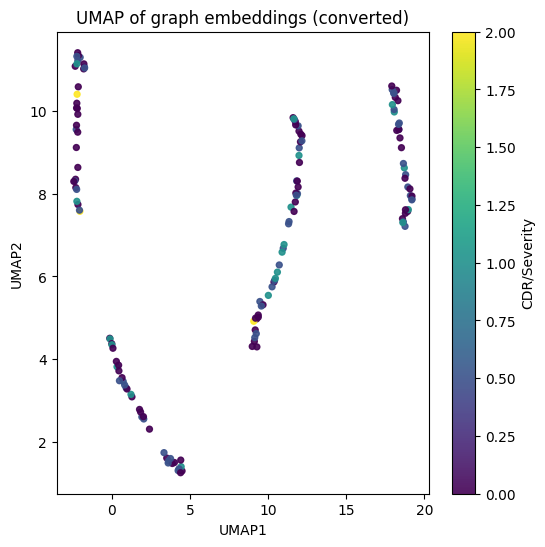

In [ ]:
# Robust convert + UMAP all-in-one cell
import os, numpy as np, torch, math
from collections import Counter
from torch_geometric.data import Data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap

BASE = "/content/drive/MyDrive/oasis_project/data/graphs"
FIG_DIR = os.path.join(BASE, "outputs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

assert 'graphs' in globals() and isinstance(graphs, (list, tuple)) and len(graphs) > 0, "No `graphs` list found in globals."

# --- 1) Inspect first 3 dict entries to understand format ---
print("\n=== Inspecting first 3 items (keys, types, shapes/previews) ===")
def preview_val(v, max_chars=200):
    try:
        if isinstance(v, (list, tuple, np.ndarray)):
            arr = np.asarray(v)
            return f"{type(v).__name__}, shape={arr.shape}, sample={arr.flatten()[:6].tolist()}"
        elif isinstance(v, torch.Tensor):
            return f"torch.Tensor, shape={tuple(v.shape)}, sample={v.detach().cpu().flatten()[:6].tolist()}"
        else:
            s = repr(v)
            return f"{type(v).__name__}, repr={s[:max_chars]}"
    except Exception as e:
        return f"unpreviewable: {e}"

for i, g in enumerate(graphs[:3]):
    print(f"\n--- graphs[{i}] type: {type(g)} ---")
    if isinstance(g, dict):
        keys = list(g.keys())
        print("keys:", keys)
        for k in keys:
            print("  ", k, "->", preview_val(g[k]))
    else:
        print("Non-dict object; print repr:", repr(g)[:500])

# --- 2) Conversion helper (aggressive rules) ---
def to_tensor(v, dtype=None):
    if isinstance(v, torch.Tensor):
        return v
    if isinstance(v, np.ndarray):
        arr = v
    elif isinstance(v, (list, tuple)):
        try:
            arr = np.asarray(v)
        except Exception:
            return None
    else:
        # scalar
        try:
            return torch.tensor(v)
        except Exception:
            return None
    if arr.size == 0:
        return None
    if dtype is None:
        if np.issubdtype(arr.dtype, np.integer):
            return torch.tensor(arr, dtype=torch.long)
        else:
            return torch.tensor(arr, dtype=torch.float32)
    else:
        return torch.tensor(arr, dtype=dtype)

# naive adjacency -> edge_index converter
def adj_to_edge_index(adj):
    arr = np.asarray(adj)
    if arr.ndim == 2 and arr.shape[0] == arr.shape[1]:
        rows, cols = np.nonzero(arr)
        ei = np.vstack([rows, cols])
        return torch.tensor(ei, dtype=torch.long)
    return None

def detect_and_extract_node_feature_from_list_of_dicts(lst):
    # e.g. [{'feat':[...]}, ...] -> convert to (N, F) array if possible
    try:
        if not isinstance(lst, (list, tuple)):
            return None
        # if each element is a dict with same keys and one key looks numeric:
        if all(isinstance(el, dict) for el in lst):
            # try to extract common numeric key
            common_keys = set(lst[0].keys())
            for el in lst[1:]:
                common_keys = common_keys & set(el.keys())
            # try each candidate key for numeric data
            for k in common_keys:
                vals = [el[k] for el in lst]
                try:
                    arr = np.asarray(vals)
                    if arr.ndim >= 1:
                        return torch.tensor(arr, dtype=(torch.float32 if not np.issubdtype(arr.dtype, np.integer) else torch.long))
                except Exception:
                    pass
    except Exception:
        pass
    return None

def dict_to_Data(d):
    if not isinstance(d, dict):
        return None
    # candidate key names
    x_keys = ['x','node_features','features','feat','node_feat','node_features_array','node_attr','attrs']
    pos_keys = ['pos','coords','centers','xyz','coord','center']
    edge_keys = ['edge_index','edges','edge_idx','edge_list','adj','adjacency','edge_indices']
    y_keys = ['y','label','cdr','target','label_score']
    id_keys = ['subject_id','subj_id','id','sid','subject']
    tp_keys = ['timepoint','tp','session']

    data = Data()
    # X
    x_val = None
    for k in x_keys:
        if k in d:
            x_val = d[k]; break
    # sometimes node features stored under 'nodes' as list-of-arrays or list-of-dicts
    if x_val is None:
        for cand in ['nodes','node','node_list']:
            if cand in d:
                x_val = d[cand]
                # if list of dicts, try extract numeric field
                if isinstance(x_val, list) and len(x_val)>0 and isinstance(x_val[0], dict):
                    extracted = detect_and_extract_node_feature_from_list_of_dicts(x_val)
                    if extracted is not None:
                        x_val = extracted
                break
    if x_val is not None:
        tx = to_tensor(x_val, dtype=torch.float32)
        if tx is not None:
            data.x = tx

    # pos
    pos_val = None
    for k in pos_keys:
        if k in d:
            pos_val = d[k]; break
    if pos_val is None:
        for cand in ['center','centers','coord']:
            if cand in d:
                pos_val = d[cand]; break
    if pos_val is not None:
        tpos = to_tensor(pos_val, dtype=torch.float32)
        if tpos is not None:
            # ensure shape (N,3) or (N,2)
            if tpos.ndim == 1:
                # single 3-vector -> broadcast
                pass
            data.pos = tpos

    # edge_index
    ei_val = None
    for k in edge_keys:
        if k in d:
            ei_val = d[k]; break
    if ei_val is not None:
        # if adjacency matrix:
        if isinstance(ei_val, (list, np.ndarray)) and np.asarray(ei_val).ndim == 2:
            arr = np.asarray(ei_val)
            if arr.shape[0] == 2 or arr.shape[1] == 2:
                # pair list (E,2) or (2,E)
                if arr.shape[0] == 2:
                    ei = torch.tensor(arr, dtype=torch.long)
                else:
                    ei = torch.tensor(arr.T, dtype=torch.long)
                data.edge_index = ei
            elif arr.shape[0] == arr.shape[1]:
                # adjacency
                ei = adj_to_edge_index(arr)
                if ei is not None:
                    data.edge_index = ei
        elif isinstance(ei_val, torch.Tensor):
            data.edge_index = ei_val.long()
    else:
        # maybe stored as adjacency in key 'adj_matrix' or 'adj'
        for cand in ['adj_matrix','adjacency_matrix','adj']:
            if cand in d:
                ei = adj_to_edge_index(d[cand])
                if ei is not None:
                    data.edge_index = ei; break

    # y / label
    y_val = None
    for k in y_keys:
        if k in d:
            y_val = d[k]; break
    if y_val is None:
        # sometimes 'meta' holds label
        if 'meta' in d and isinstance(d['meta'], dict):
            for k in y_keys:
                if k in d['meta']:
                    y_val = d['meta'][k]; break
    if y_val is not None:
        ty = to_tensor(y_val)
        if ty is not None:
            # ensure shape (1,) or scalar
            if ty.ndim == 0:
                ty = ty.unsqueeze(0)
            data.y = ty.float()

    # subject id and timepoint
    for k in id_keys:
        if k in d:
            try:
                data.subject_id = d[k]; break
            except:
                pass
    for k in tp_keys:
        if k in d:
            try:
                data.timepoint = d[k]; break
            except:
                pass

    # If edges missing but x present, create isolated-graph edge_index empty
    if not hasattr(data, 'edge_index') and hasattr(data, 'x'):
        # create empty edge_index
        data.edge_index = torch.empty((2,0), dtype=torch.long)

    # Final guard: require x and edge_index (or x and pos)
    if not hasattr(data, 'x') and not hasattr(data, 'pos'):
        return None
    return data

# --- 3) Convert whole list ---
converted = []
skipped = []
for idx, g in enumerate(graphs):
    if isinstance(g, dict):
        d = dict_to_Data(g)
        if d is None:
            skipped.append(idx)
        else:
            converted.append(d)
    elif isinstance(g, Data):
        converted.append(g)
    else:
        # unknown object: try to coerce by attempting to access .x
        try:
            if hasattr(g, 'x'):
                converted.append(g)
            else:
                skipped.append(idx)
        except Exception:
            skipped.append(idx)

print(f"\nConversion done: converted={len(converted)}, skipped={len(skipped)} (sample skipped idxs: {skipped[:10]})")
if len(converted) == 0:
    raise RuntimeError("Conversion produced zero graphs — check the printed first-3 inspection above and paste that output here for me to adapt the converter.")

# Overwrite globals graphs
graphs = converted
globals()['graphs'] = graphs

# --- 4) Basic sanity counts & ensure y exists ---
missing_counts = Counter()
for i,g in enumerate(graphs[:50]):
    for a in ('x','edge_index','pos','y'):
        if not hasattr(g, a):
            missing_counts[a]+=1
print("Missing attr counts in first 50 graphs (how many lack the attribute):", missing_counts)

for g in graphs:
    if not hasattr(g, 'y') or g.y is None:
        g.y = torch.tensor([float('nan')])

# --- 5) Compute embeddings using encoder (robust) ---
assert 'encoder' in globals(), "encoder missing in globals (create model/encoder first)."
encoder = globals()['encoder']

def graph_to_embedding(graph):
    try:
        out = encoder(graph)
    except Exception:
        # try model(x, edge_index, batch)
        x = graph.x.to(device)
        ei = graph.edge_index.to(device) if hasattr(graph, 'edge_index') else None
        batch = getattr(graph, 'batch', None)
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=device)
        else:
            batch = batch.to(device)
        out = encoder(x, ei, batch)
    if isinstance(out, torch.Tensor):
        return out.detach().cpu().numpy().squeeze()
    else:
        return np.array(out).squeeze()

embs = []
labels = []
ids = []
failed = []
print("\nComputing embeddings for {} graphs...".format(len(graphs)))
for i,g in enumerate(graphs):
    try:
        if not hasattr(g, 'batch') or g.batch is None:
            g.batch = torch.zeros(getattr(g, 'num_nodes', g.x.size(0)), dtype=torch.long)
        emb = graph_to_embedding(g)
        embs.append(emb)
        labels.append(float(g.y.item()) if hasattr(g,'y') and not torch.isnan(g.y).any() else np.nan)
        ids.append(getattr(g, 'subject_id', f"idx_{i}"))
    except Exception as e:
        failed.append((i, str(e)))
        continue

print("Embeddings computed:", len(embs), "Failed:", len(failed), "Sample failures:", failed[:10])
if len(embs) == 0:
    raise RuntimeError("No embeddings computed. See failures above and the initial inspection output.")

embs = np.vstack(embs)
print("Final embeddings shape:", embs.shape)

# Save embeddings csv
df = pd.DataFrame(embs)
df['label'] = labels
df['subject_id'] = ids
out_tsv = os.path.join(FIG_DIR, "embeddings_converted.tsv")
df.to_csv(out_tsv, sep='\t', index=False)
print("Saved embeddings TSV ->", out_tsv)

# UMAP
scaler = StandardScaler()
embs_scaled = scaler.fit_transform(embs)
proj = umap.UMAP(n_components=2, random_state=42).fit_transform(embs_scaled)
plt.figure(figsize=(6,6))
sc = plt.scatter(proj[:,0], proj[:,1], c=labels if any([not np.isnan(x) for x in labels]) else None, cmap='viridis', s=18, alpha=0.9)
if any([not np.isnan(x) for x in labels]):
    plt.colorbar(sc, label='CDR/Severity')
plt.title('UMAP of graph embeddings (converted)')
plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
out_png = os.path.join(FIG_DIR, "umap_embeddings_converted.png")
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print("Saved UMAP ->", out_png)
plt.show()


k=2 silhouette=0.8566
k=3 silhouette=0.6584
k=4 silhouette=0.6260
k=5 silhouette=0.5803
k=6 silhouette=0.5430
k=7 silhouette=0.5277


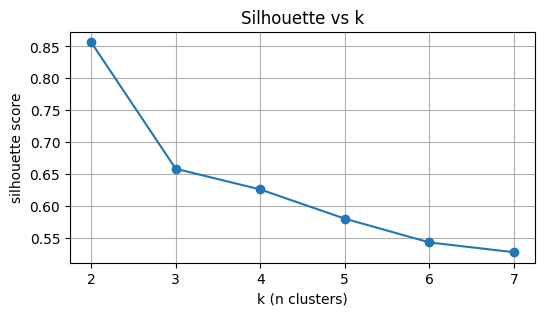

Saved cluster assignment CSV: /content/drive/MyDrive/oasis_project/outputs/figures/clusters_k4.csv


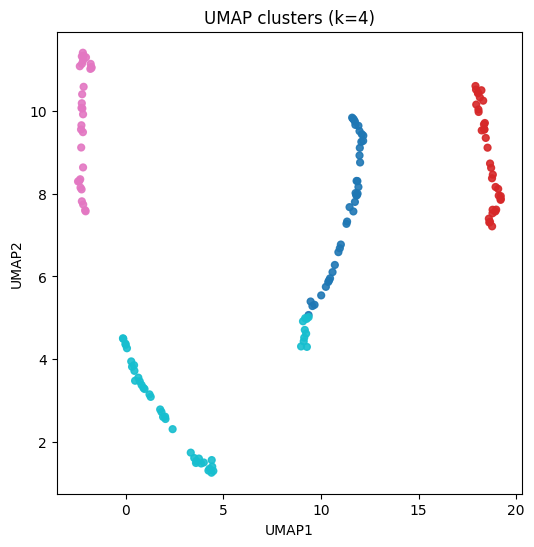

In [ ]:
# A_clustering_and_umap.py cell
import os, numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

BASE = "/content/drive/MyDrive/oasis_project"
FIG_DIR = os.path.join(BASE, "outputs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# use variables from previous steps: embs (numpy n x d), proj (umap 2D), labels (list)
assert 'embs' in globals(), "embs not found — rerun embedding cell."
embs_arr = np.array(embs)  # shape (N, D)
lbls = np.array(labels) if 'labels' in globals() else None
ids = list(ids) if 'ids' in globals() else [f"g{i}" for i in range(len(embs_arr))]

# Silhouette for range of k
ks = list(range(2,8))  # adjust upper bound if you want
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(embs_arr)
    lab = km.labels_
    try:
        s = silhouette_score(embs_arr, lab)
    except Exception:
        s = float('nan')
    sil_scores.append(s)
    print(f"k={k} silhouette={s:.4f}")

plt.figure(figsize=(6,3))
plt.plot(ks, sil_scores, '-o')
plt.xlabel('k (n clusters)')
plt.ylabel('silhouette score')
plt.title('Silhouette vs k')
plt.grid(True)
plt.savefig(os.path.join(FIG_DIR, "silhouette_k.png"), dpi=150, bbox_inches='tight')
plt.show()

# Choose k (you can change below)
k = 4
km = KMeans(n_clusters=k, random_state=42).fit(embs_arr)
clusters = km.labels_

# Save cluster assignments
dfc = pd.DataFrame({"subject_id": ids, "label": lbls.tolist() if lbls is not None else [None]*len(ids), "cluster": clusters})
dfc.to_csv(os.path.join(FIG_DIR, f"clusters_k{k}.csv"), index=False)
print("Saved cluster assignment CSV:", os.path.join(FIG_DIR, f"clusters_k{k}.csv"))

# Plot clusters on UMAP (proj is UMAP 2D from prior cell)
if 'proj' in globals():
    plt.figure(figsize=(6,6))
    plt.scatter(proj[:,0], proj[:,1], c=clusters, cmap='tab10', s=24, alpha=0.9)
    plt.title(f'UMAP clusters (k={k})')
    plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
    plt.savefig(os.path.join(FIG_DIR, f"umap_clusters_k{k}.png"), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("proj (UMAP 2D) not found in globals — skipping UMAP cluster plot.")


In [ ]:
# Pick representative graphs per cluster (closest to centroid in embedding space)
import os, numpy as np, pandas as pd
from sklearn.metrics import pairwise_distances
BASE = "/content/drive/MyDrive/oasis_project"
FIG_DIR = os.path.join(BASE, "outputs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# params
n_reps_per_cluster = 4  # change if you want fewer/more reps

# load embeddings & cluster assignments
embs_arr = None
if 'embs' in globals():
    embs_arr = np.array(embs)
else:
    # try loading saved embeddings file
    emb_file = os.path.join(FIG_DIR, "embeddings_converted.tsv")
    if os.path.exists(emb_file):
        emb_df = pd.read_csv(emb_file, sep='\t')
        # first columns are embedding dims
        embs_arr = emb_df.iloc[:, :emb_df.shape[1]-2].values  # last cols label, id
    else:
        raise RuntimeError("embs not found in globals and no embeddings TSV found")

clusters_csv = os.path.join(FIG_DIR, "clusters_k4.csv")
if not os.path.exists(clusters_csv):
    raise RuntimeError("clusters_k4.csv not found; run clustering cell first")
clusters_df = pd.read_csv(clusters_csv)

# build id->index mapping (ids from embeddings generation)
if 'ids' in globals():
    id_list = list(ids)
else:
    # fallback read from embeddings file
    emb_df = pd.read_csv(os.path.join(FIG_DIR, "embeddings_converted.tsv"), sep='\t') if os.path.exists(os.path.join(FIG_DIR, "embeddings_converted.tsv")) else pd.read_csv(os.path.join(FIG_DIR,"embeddings_converted.tsv"), sep='\t', engine='python')
    id_list = emb_df['subject_id'].tolist()

id2idx = {sid: i for i, sid in enumerate(id_list)}

# compute cluster centroids and nearest samples
clusters = clusters_df['cluster'].values
subjects = clusters_df['subject_id'].values
unique_clusters = sorted(np.unique(clusters))
rep_indices = {}  # cluster -> list of graph indices
for c in unique_clusters:
    c_subjects = clusters_df[clusters_df['cluster']==c]['subject_id'].values
    idxs = [id2idx[sid] for sid in c_subjects if sid in id2idx]
    if len(idxs) == 0:
        rep_indices[c] = []
        continue
    emb_subset = embs_arr[idxs]
    centroid = emb_subset.mean(axis=0, keepdims=True)
    dists = pairwise_distances(emb_subset, centroid).reshape(-1)
    nearest_order = np.argsort(dists)[:n_reps_per_cluster]
    reps = [idxs[i] for i in nearest_order]
    rep_indices[c] = reps

# Save representative mapping
rep_rows = []
for c, reps in rep_indices.items():
    for r in reps:
        rep_rows.append({"cluster": int(c), "graph_index": int(r), "subject_id": id_list[r]})
rep_df = pd.DataFrame(rep_rows)
out_rep = os.path.join(FIG_DIR, "cluster_representatives_k4.csv")
rep_df.to_csv(out_rep, index=False)
print("Saved representatives CSV:", out_rep)
print("Representative counts per cluster:", rep_df.groupby('cluster').size().to_dict())
rep_df.head(20)


Saved representatives CSV: /content/drive/MyDrive/oasis_project/outputs/figures/cluster_representatives_k4.csv
Representative counts per cluster: {0: 4, 1: 4, 2: 4, 3: 4}


,cluster,graph_index,subject_id
0,0,100,graph_0119_subj_119
1,0,99,graph_0118_subj_118
2,0,141,graph_0175_subj_175
3,0,88,graph_0104_subj_104
4,1,98,graph_0117_subj_117
5,1,26,graph_0032_subj_32
6,1,22,graph_0028_subj_28
7,1,63,graph_0075_subj_75
8,2,47,graph_0055_subj_55
9,2,102,graph_0121_subj_121


In [ ]:
# Robust gradient explainer + PCA fallback for missing pos (representatives only)
import os, numpy as np, torch, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

BASE = "/content/drive/MyDrive/oasis_project"
FIG_DIR = os.path.join(BASE, "outputs", "figures")
rep_csv = os.path.join(FIG_DIR, "cluster_representatives_k4.csv")
assert os.path.exists(rep_csv), "Representative CSV not found; run selection cell first"
rep_df = pd.read_csv(rep_csv)

# prepare model and device (we use gradient explainer)
assert 'model' in globals() and model is not None, "model not in globals; load model first"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
print("Using gradient-based explainer on device:", device)

# overlay helper
def overlay_and_save(pos, vals, outpath, title=None, z_axis=2, z_tol=8):
    pos = pos.copy()
    z_slice = int(np.nanmean(pos[:, z_axis]))
    sel = np.abs(pos[:, z_axis] - z_slice) < z_tol
    plt.figure(figsize=(6,6))
    plt.imshow(np.zeros((10,10)), cmap='gray', alpha=0)  # blank background
    sc = plt.scatter(pos[sel,0], pos[sel,1], s=60*(vals[sel]/(vals[sel].max()+1e-9)+0.01), c=vals[sel], cmap='hot')
    plt.colorbar(sc, label='importance')
    if title: plt.title(title)
    plt.axis('off')
    plt.savefig(outpath, dpi=150, bbox_inches='tight')
    plt.close()

summary_rows = []

for _, row in rep_df.iterrows():
    idx = int(row['graph_index'])
    subj = row['subject_id']
    cl = int(row['cluster'])
    g = graphs[idx]  # expected to be torch_geometric.data.Data
    # ensure we have node features
    if not hasattr(g, 'x') or g.x is None:
        print(f"Graph {subj} idx={idx} has no x; skipping.")
        continue

    # move tensors to device; but keep a cpu-copy for saving overlays
    x_cpu = g.x.detach().cpu()
    num_nodes = x_cpu.size(0)

    # compute positions: use existing pos if available, else PCA on x
    if hasattr(g, 'pos') and g.pos is not None:
        try:
            coords = g.pos.detach().cpu().numpy()
            if coords.shape[0] != num_nodes:
                # mismatch, fallback to PCA
                raise ValueError("pos length mismatch")
            pos_source = "pos"
        except Exception:
            # fallback to PCA
            coords = PCA(n_components=3).fit_transform(x_cpu.numpy())
            pos_source = "pca"
    else:
        coords = PCA(n_components=3).fit_transform(x_cpu.numpy())
        pos_source = "pca"

    # gradient-based node importance
    model.zero_grad()
    x = g.x.clone().to(device).requires_grad_(True)
    ei = g.edge_index.to(device) if hasattr(g, 'edge_index') else None
    batch = getattr(g, 'batch', None)
    if batch is None:
        batch = torch.zeros(x.size(0), dtype=torch.long, device=device)
    else:
        batch = batch.to(device)

    # forward -> obtain scalar
    try:
        out = model(x, ei, batch)
    except Exception:
        out = model(g)  # fallback

    # reduce to scalar
    if isinstance(out, torch.Tensor):
        if out.dim() == 2 and out.shape[1] == 1:
            scalar = out[0,0]
        elif out.dim() == 1:
            scalar = out[0]
        else:
            scalar = out.reshape(-1).sum()
    else:
        raise RuntimeError("Model forward returned non-tensor")

    # backward
    scalar.backward(retain_graph=False)
    grad = x.grad.detach().cpu().abs()  # shape (N_nodes, n_feats)
    node_imp = grad.sum(dim=1).numpy()  # L1 across features

    # cleanup
    model.zero_grad()
    x.requires_grad_(False)

    # Save CSV for this rep
    out_csv = os.path.join(FIG_DIR, f"rep_{subj}_node_importance_gradient.csv")
    pd.DataFrame({"node_idx": np.arange(num_nodes), "importance": node_imp}).to_csv(out_csv, index=False)

    # Overlay and save - use coords (either original pos or PCA)
    out_png = os.path.join(FIG_DIR, f"rep_{subj}_node_imp_overlay_gradient.png")
    try:
        overlay_and_save(coords, node_imp, out_png, title=f"{subj} cluster={cl} (pos_source={pos_source})")
    except Exception as e:
        print(f"Overlay failed for {subj}: {e}")
        # fallback: scatter without z-slice filtering
        plt.figure(figsize=(6,6))
        sc = plt.scatter(coords[:,0], coords[:,1], s=60*(node_imp/(node_imp.max()+1e-9)+0.01), c=node_imp, cmap='hot')
        plt.colorbar(sc, label='importance')
        plt.title(f"{subj} cluster={cl} (fallback overlay)")
        plt.savefig(out_png, dpi=150, bbox_inches='tight')
        plt.close()

    summary_rows.append({
        "subject_id": subj,
        "graph_index": idx,
        "cluster": cl,
        "node_imp_csv": out_csv,
        "overlay_png": out_png,
        "pos_source": pos_source
    })
    print("Saved for", subj, "pos_source=", pos_source)

# summary CSV
summary_path = os.path.join(FIG_DIR, "rep_explainer_summary_gradient.csv")
pd.DataFrame(summary_rows).to_csv(summary_path, index=False)
print("Done. Summary saved to:", summary_path)


Using gradient-based explainer on device: cuda
Saved for graph_0119_subj_119 pos_source= pca
Saved for graph_0118_subj_118 pos_source= pca
Saved for graph_0175_subj_175 pos_source= pca
Saved for graph_0104_subj_104 pos_source= pca
Saved for graph_0117_subj_117 pos_source= pca
Saved for graph_0032_subj_32 pos_source= pca
Saved for graph_0028_subj_28 pos_source= pca
Saved for graph_0075_subj_75 pos_source= pca
Saved for graph_0055_subj_55 pos_source= pca
Saved for graph_0121_subj_121 pos_source= pca
Saved for graph_0183_subj_183 pos_source= pca
Saved for graph_0120_subj_120 pos_source= pca
Saved for graph_0053_subj_53 pos_source= pca
Saved for graph_0127_subj_127 pos_source= pca
Saved for graph_0021_subj_21 pos_source= pca
Saved for graph_0051_subj_51 pos_source= pca
Done. Summary saved to: /content/drive/MyDrive/oasis_project/outputs/figures/rep_explainer_summary_gradient.csv


In [ ]:
# Aggregate rep explainabilities -> cluster mean overlays (handles gradient vs gnnexplainer summaries)
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

BASE = "/content/drive/MyDrive/oasis_project"
FIG_DIR = os.path.join(BASE, "outputs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# prefer gradient summary if present
cand_paths = [
    os.path.join(FIG_DIR, "rep_explainer_summary_gradient.csv"),
    os.path.join(FIG_DIR, "rep_gnnexplainer_summary.csv"),
    os.path.join(FIG_DIR, "rep_explainer_summary_gnnexplainer.csv")
]
summary_path = next((p for p in cand_paths if os.path.exists(p)), None)
if summary_path is None:
    raise FileNotFoundError("No rep_explainer_summary CSV found. Looked for: " + ", ".join(cand_paths))
print("Using summary:", summary_path)

rep_df = pd.read_csv(summary_path)
print("Loaded rep summary rows:", len(rep_df))

# read all per-rep node importance arrays and group by cluster
cluster_vals = {}
for _, r in rep_df.iterrows():
    c = int(r['cluster'])
    node_csv = r.get('node_imp_csv', None) or r.get('node_imp_csv', None)
    if not node_csv or not os.path.exists(node_csv):
        print("Missing per-rep CSV for:", r.get('subject_id'), "path:", node_csv)
        continue
    arr = pd.read_csv(node_csv)['importance'].values
    cluster_vals.setdefault(c, []).append(arr)

# compute cluster means and save
cluster_mean = {}
for c, arrs in cluster_vals.items():
    stacked = np.vstack(arrs)  # (n_reps, n_nodes)
    meanv = stacked.mean(axis=0)
    cluster_mean[c] = meanv
cluster_ids = sorted(cluster_mean.keys())

out_npy = os.path.join(FIG_DIR, "cluster_mean_node_importance_reps.npy")
# convert to array with shape (n_clusters, n_nodes) filling missing clusters with NaN rows if needed
max_nodes = max(v.shape[0] for v in cluster_mean.values())
cmat = np.zeros((len(cluster_ids), max_nodes))
cmat[:] = np.nan
for i,c in enumerate(cluster_ids):
    v = cluster_mean[c]
    cmat[i,:v.shape[0]] = v
np.save(out_npy, cmat)
# Save csv with cluster rows
import csv
csv_out = os.path.join(FIG_DIR, "cluster_mean_node_importance_reps.csv")
with open(csv_out, 'w', newline='') as f:
    writer = csv.writer(f)
    # header: node_0, node_1, ...
    header = [f"node_{i}" for i in range(max_nodes)]
    header = ["cluster"] + header
    writer.writerow(header)
    for i,c in enumerate(cluster_ids):
        row = [c] + cmat[i].tolist()
        writer.writerow(row)
print("Saved cluster mean npy:", out_npy)
print("Saved cluster mean csv:", csv_out)

# overlay on coords (use graphs[0].pos if present else PCA from graphs[0].x)
if 'graphs' not in globals() or len(graphs) == 0:
    raise RuntimeError("`graphs` not in globals or empty. Need graphs for node coordinates.")
g0 = graphs[0]
if hasattr(g0, 'pos') and g0.pos is not None:
    coords = g0.pos.detach().cpu().numpy()
    pos_source = "pos"
else:
    print("graphs[0].pos missing -> computing PCA coords from graphs[0].x")
    coords = PCA(n_components=3).fit_transform(g0.x.detach().cpu().numpy())
    pos_source = "pca"

# plotting overlays for each cluster
z_axis = 2
z_tol = 8
z_slice = int(coords[:, z_axis].mean())
sel = np.abs(coords[:, z_axis] - z_slice) < z_tol
for i,c in enumerate(cluster_ids):
    vals = cmat[i]
    if np.all(np.isnan(vals)):
        print("Cluster", c, "has no values; skipping")
        continue
    # if cluster mean has fewer nodes than coords, broadcast/pad with zeros
    if vals.shape[0] < coords.shape[0]:
        vals_full = np.zeros(coords.shape[0])
        vals_full[:vals.shape[0]] = vals
        vals = vals_full
    # select nodes near slice and plot
    plt.figure(figsize=(6,6))
    plt.scatter(coords[sel,0], coords[sel,1],
                s=60*(vals[sel]/(np.nanmax(vals[sel]) + 1e-9) + 0.01),
                c=vals[sel], cmap='hot')
    plt.colorbar(label='mean importance')
    plt.title(f"Cluster {c} mean node importance (reps) — pos_source={pos_source}")
    plt.axis('off')
    out_png = os.path.join(FIG_DIR, f"cluster_{c}_mean_node_importance_reps_overlay.png")
    plt.savefig(out_png, dpi=150, bbox_inches='tight')
    plt.close()
    print("Saved overlay:", out_png)

# OPTIONAL: overlay onto NIfTI slice (enable and set pattern)
use_nifti = False
nifti_pattern = os.path.join(BASE, "data", "preproc", "{subject_id}_T1_preproc.nii.gz")  # edit if needed
if use_nifti:
    try:
        import nibabel as nib
        for i,c in enumerate(cluster_ids):
            vals = cmat[i]
            # find subject to get a reference anatomy (pick first rep in cluster)
            reps = rep_df[rep_df['cluster']==c]
            if len(reps)==0:
                continue
            subj = reps.iloc[0]['subject_id']
            nif_path = nifti_pattern.format(subject_id=subj)
            if not os.path.exists(nif_path):
                print("NIfTI not found for subj", subj, "path", nif_path)
                continue
            print("Loading NIfTI:", nif_path)
            img = nib.load(nif_path)
            arr = img.get_fdata()
            # pick slice index matching z coordinate (approx center)
            z_slice_idx = arr.shape[2] // 2
            slice_img = arr[:, :, z_slice_idx].T  # transpose for display orientation
            plt.figure(figsize=(6,6))
            plt.imshow(slice_img, cmap='gray', interpolation='nearest')
            # overlay scatter (project coords to slice) — assumes coords in voxel space; may need scaling
            sel = np.abs(coords[:,2] - coords[:,2].mean()) < z_tol
            sc = plt.scatter(coords[sel,0], coords[sel,1], s=60*(vals[sel]/(np.nanmax(vals[sel])+1e-9)+0.01), c=vals[sel], cmap='hot')
            plt.colorbar(sc)
            out_png = os.path.join(FIG_DIR, f"cluster_{c}_mean_node_importance_nifti_overlay.png")
            plt.savefig(out_png, dpi=150, bbox_inches='tight')
            plt.close()
            print("Saved NIfTI overlay:", out_png)
    except Exception as e:
        print("NIfTI overlay failed:", e)

print("All done. Files saved in:", FIG_DIR)


Using summary: /content/drive/MyDrive/oasis_project/outputs/figures/rep_explainer_summary_gradient.csv
Loaded rep summary rows: 16
Saved cluster mean npy: /content/drive/MyDrive/oasis_project/outputs/figures/cluster_mean_node_importance_reps.npy
Saved cluster mean csv: /content/drive/MyDrive/oasis_project/outputs/figures/cluster_mean_node_importance_reps.csv
graphs[0].pos missing -> computing PCA coords from graphs[0].x
Saved overlay: /content/drive/MyDrive/oasis_project/outputs/figures/cluster_0_mean_node_importance_reps_overlay.png
Saved overlay: /content/drive/MyDrive/oasis_project/outputs/figures/cluster_1_mean_node_importance_reps_overlay.png
Saved overlay: /content/drive/MyDrive/oasis_project/outputs/figures/cluster_2_mean_node_importance_reps_overlay.png
Saved overlay: /content/drive/MyDrive/oasis_project/outputs/figures/cluster_3_mean_node_importance_reps_overlay.png
All done. Files saved in: /content/drive/MyDrive/oasis_project/outputs/figures


In [ ]:
# Merge demographics Excel with cluster assignments and produce summaries + plots
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/oasis_project"
FIG_DIR = os.path.join(BASE, "outputs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

clusters_csv = os.path.join(FIG_DIR, "clusters_k4.csv")
demo_xlsx = os.path.join(BASE, "data", "demographics", "oasis2_demographics.xlsx")
out_merged = os.path.join(FIG_DIR, "cluster_demographics_merged_k4.csv")

if not os.path.exists(clusters_csv):
    raise RuntimeError(f"clusters file not found: {clusters_csv}")
if not os.path.exists(demo_xlsx):
    raise RuntimeError(f"demographics excel not found: {demo_xlsx}")

# 1) load files
clusters_df = pd.read_csv(clusters_csv)
print("Loaded clusters (head):")
print(clusters_df.head())

# Read the first sheet by default, but if there are many sheets we'll inspect them
xls = pd.ExcelFile(demo_xlsx)
print("Found sheets in demographics Excel:", xls.sheet_names[:10])
# read first sheet
demo = pd.read_excel(xls, sheet_name=0)
print("Demographics columns:", demo.columns.tolist())
print("Demographics preview:")
print(demo.head())

# 2) try to detect subject id column and rename to `subject_id`
possible_id_cols = ['subject_id','subject id','subject','subj_id','subj','id','ID','RID','SubjectID','SUBJECT_ID']
demo_cols_lower = {c.lower(): c for c in demo.columns}
found_id_col = None
for cand in possible_id_cols:
    if cand.lower() in demo_cols_lower:
        found_id_col = demo_cols_lower[cand.lower()]
        break

if found_id_col is None:
    # as a fallback, try to find a column that contains string-like IDs starting with 'graph_' or 'subj'
    for c in demo.columns:
        sample_vals = demo[c].dropna().astype(str).values[:10]
        if len(sample_vals)>0 and any(s.lower().startswith('graph_') or 'subj' in s.lower() or s.isdigit() for s in sample_vals):
            found_id_col = c
            break

if found_id_col is None:
    print("Could not automatically detect a subject id column in the demographics file. Columns are:")
    for c in demo.columns:
        print(" -", c)
    raise RuntimeError("Please inspect the demographics file and provide the subject ID column name (rename it to 'subject_id' or re-run with a mapping).")
else:
    print("Detected subject id column in demographics:", found_id_col)
    demo = demo.rename(columns={found_id_col: 'subject_id'})

# ensure subject_id strings match cluster CSV format (strip/normalize)
demo['subject_id'] = demo['subject_id'].astype(str).str.strip()

# 3) merge on subject_id
merged = clusters_df.merge(demo, on='subject_id', how='left')
print("Merged dataframe shape:", merged.shape)
print("Merged head:")
print(merged.head())

# Save merged table
merged.to_csv(out_merged, index=False)
print("Saved merged CSV to:", out_merged)

# 4) Choose numeric columns to summarize
numeric_candidates = ['age','mmse','apoe','Age','MMSE','APOE']
numeric_cols = []
for nc in numeric_candidates:
    if nc in merged.columns:
        numeric_cols.append(nc)
# unify to lowercase names if necessary
merged = merged.rename(columns={c:c.lower() for c in merged.columns if c.lower() in numeric_candidates})
# ensure we use lowercase column names if present
for c in ['age','mmse','apoe']:
    if c in merged.columns and c not in numeric_cols:
        numeric_cols.append(c)

numeric_cols = [c for c in ['age','mmse','apoe'] if c in merged.columns]
print("Numeric columns to summarize:", numeric_cols)

# 5) groupby cluster stats
if len(numeric_cols)>0:
    stats = merged.groupby('cluster')[numeric_cols].agg(['mean','std','count'])
    stats_path = os.path.join(FIG_DIR, "cluster_demographics_summary_k4.csv")
    # flatten columns
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
    stats.to_csv(stats_path)
    print("Saved cluster demographics stats to:", stats_path)
    print(stats)
else:
    print("No numeric demographic columns found to summarize.")

# 6) plots: cluster sizes, age boxplot, mmse boxplot, cdr distribution (if label present)
# Cluster sizes
cluster_counts = merged['cluster'].value_counts().sort_index()
plt.figure(figsize=(6,4))
cluster_counts.plot(kind='bar')
plt.xlabel('cluster'); plt.ylabel('n subjects'); plt.title('Cluster sizes (k=4)')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "cluster_sizes_k4.png"), dpi=150)
plt.close()
print("Saved cluster sizes plot.")

# Age boxplot
if 'age' in merged.columns:
    plt.figure(figsize=(6,4))
    merged.boxplot(column='age', by='cluster')
    plt.title('Age by cluster'); plt.suptitle('')
    plt.xlabel('cluster'); plt.ylabel('age')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "age_by_cluster_k4.png"), dpi=150)
    plt.close()
    print("Saved age boxplot.")

# MMSE boxplot
if 'mmse' in merged.columns:
    plt.figure(figsize=(6,4))
    merged.boxplot(column='mmse', by='cluster')
    plt.title('MMSE by cluster'); plt.suptitle('')
    plt.xlabel('cluster'); plt.ylabel('mmse')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "mmse_by_cluster_k4.png"), dpi=150)
    plt.close()
    print("Saved MMSE boxplot.")

# APOE distribution (counts) per cluster
if 'apoe' in merged.columns:
    try:
        # if apoe numeric, bin or show mean per cluster
        if np.issubdtype(merged['apoe'].dtype, np.number):
            ap_stat = merged.groupby('cluster')['apoe'].value_counts().unstack(fill_value=0)
            ap_stat.to_csv(os.path.join(FIG_DIR, "apoe_counts_by_cluster_k4.csv"))
            print("Saved APOE counts by cluster.")
        else:
            ap_stat = merged.groupby('cluster')['apoe'].value_counts()
            print(ap_stat)
    except Exception as e:
        print("APOE summary failed:", e)

# CDR/label distribution if present
if 'label' in merged.columns or 'cdr' in merged.columns or 'y' in merged.columns:
    label_col = 'label' if 'label' in merged.columns else ('cdr' if 'cdr' in merged.columns else 'y')
    plt.figure(figsize=(6,4))
    pd.crosstab(merged['cluster'], merged[label_col]).plot(kind='bar', stacked=True, figsize=(6,4))
    plt.xlabel('cluster'); plt.ylabel('count'); plt.title('Label distribution by cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "label_distribution_by_cluster_k4.png"), dpi=150)
    plt.close()
    print("Saved label distribution plot.")

print("Done. All outputs saved to:", FIG_DIR)


Loaded clusters (head):
          subject_id  label  cluster
0  graph_0001_subj_1    0.0        1
1  graph_0002_subj_2    0.5        2
2  graph_0003_subj_3    0.0        0
3  graph_0004_subj_4    0.0        1
4  graph_0005_subj_5    0.0        3
Found sheets in demographics Excel: ['Sheet1']
Demographics columns: ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Demographics preview:
  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR         eTIV      nWBV      

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [ ]:
# Fix KeyError, inspect merged columns, ensure oasis_id exists, recompute summaries + save
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/oasis_project"
FIG_DIR = os.path.join(BASE, "outputs", "figures")
clusters_csv = os.path.join(FIG_DIR, "clusters_k4.csv")
mapped_out = os.path.join(FIG_DIR, "cluster_demographics_merged_k4_mapped.csv")
summary_out = os.path.join(FIG_DIR, "cluster_demographics_summary_k4_mapped.csv")

# Reload clusters and demographics to ensure clean state
clusters_df = pd.read_csv(clusters_csv)
demo_xlsx = os.path.join(BASE, "data", "demographics", "oasis2_demographics.xlsx")
xls = pd.ExcelFile(demo_xlsx)
demo = pd.read_excel(xls, sheet_name=0)

# (Re)build oasis_id from graph subject_id (same mapping as before)
import re
def graphid_to_oasis(graph_id):
    if not isinstance(graph_id, str):
        return None
    m = re.search(r'(\d{1,4})', graph_id)
    if not m:
        return None
    num = m.group(1).zfill(4)
    return f"OAS2_{num}"

clusters_df = clusters_df.copy()
clusters_df['oasis_id'] = clusters_df['subject_id'].astype(str).apply(graphid_to_oasis)

# Choose demographics row per subject (use Visit==1 where present)
if 'Visit' in demo.columns:
    demo_sel = []
    for sid, group in demo.groupby('Subject ID'):
        if 1 in group['Visit'].values:
            demo_sel.append(group[group['Visit']==1].iloc[0])
        else:
            demo_sel.append(group.sort_values('Visit').iloc[0])
    demo_sel = pd.DataFrame(demo_sel)
else:
    demo_sel = demo.copy()

# ensure demo_sel has Subject ID column preserved and name it oasis_id for merging
if 'Subject ID' in demo_sel.columns:
    demo_sel = demo_sel.rename(columns={'Subject ID': 'oasis_id'})
elif 'subject id' in [c.lower() for c in demo_sel.columns]:
    # find the exact column name
    for c in demo_sel.columns:
        if c.lower() == 'subject id':
            demo_sel = demo_sel.rename(columns={c: 'oasis_id'})
            break
else:
    # fallback: try 'subject_id' or other variants
    for cand in ['subject_id','SubjectID','SUBJECT_ID','ID','id']:
        if cand in demo_sel.columns:
            demo_sel = demo_sel.rename(columns={cand: 'oasis_id'})
            break

# Print columns for debugging
print("clusters_df columns:", clusters_df.columns.tolist())
print("demo_sel columns:", demo_sel.columns.tolist())

# Merge (left join clusters -> demo_sel)
merged = clusters_df.merge(demo_sel, on='oasis_id', how='left', suffixes=('','_dem'))
print("Merged shape:", merged.shape)
print("Number of clusters rows with oasis match:", merged['oasis_id'].notnull().sum(), "out of", len(merged))

# show merged columns and a sample of unmatched subject_ids
print("\nMerged columns preview:")
print(merged.columns.tolist())
if 'oasis_id' in merged.columns:
    unmatched = merged[merged['oasis_id'].isnull()]
    print("Unmatched rows (first 10 subject_id):", unmatched['subject_id'].head(10).tolist())
else:
    print("WARNING: 'oasis_id' column not present after merge. Columns are:", merged.columns.tolist())

# Identify numeric demographic columns to summarize (try common names)
numeric_candidates = ['Age','age','MMSE','mmse','CDR','cdr','APOE','apoe']
found_numeric = []
for cand in numeric_candidates:
    for col in merged.columns:
        if col.lower() == cand.lower():
            found_numeric.append(col)
            break
print("Found numeric demographic columns:", found_numeric)

# Normalize names to lowercase simple keys if present
for col in merged.columns:
    if col.lower() == 'age':
        merged = merged.rename(columns={col:'age'})
    if col.lower() == 'mmse':
        merged = merged.rename(columns={col:'mmse'})
    if col.lower() == 'cdr':
        merged = merged.rename(columns={col:'cdr'})

# Final numeric cols to summarize
numeric_cols = [c for c in ['age','mmse','cdr'] if c in merged.columns]
print("Numeric cols used for summary:", numeric_cols)

if len(numeric_cols) > 0:
    stats = merged.groupby('cluster')[numeric_cols].agg(['mean','std','count'])
    # flatten multiindex
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
    stats.to_csv(summary_out)
    print("Saved cluster demographics summary to:", summary_out)
    print(stats)
else:
    print("No numeric demographic cols found; skipping stats save.")

# Save merged table for inspection
merged.to_csv(mapped_out, index=False)
print("Saved merged table to:", mapped_out)

# Produce simple plots if values present
plt.figure(figsize=(6,4))
merged['cluster'].value_counts().sort_index().plot(kind='bar')
plt.title('Cluster sizes (k=4)')
plt.xlabel('cluster'); plt.ylabel('n')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "cluster_sizes_k4_mapped.png"), dpi=150)
plt.close()
print("Saved cluster sizes plot.")

if 'age' in merged.columns:
    plt.figure(figsize=(6,4))
    merged.boxplot(column='age', by='cluster')
    plt.title('Age by cluster'); plt.suptitle('')
    plt.xlabel('cluster'); plt.ylabel('age')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "age_by_cluster_k4_mapped.png"), dpi=150)
    plt.close()
    print("Saved age boxplot.")

if 'mmse' in merged.columns:
    plt.figure(figsize=(6,4))
    merged.boxplot(column='mmse', by='cluster')
    plt.title('MMSE by cluster'); plt.suptitle('')
    plt.xlabel('cluster'); plt.ylabel('mmse')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "mmse_by_cluster_k4_mapped.png"), dpi=150)
    plt.close()
    print("Saved mmse boxplot.")

print("Done — merged table + summaries saved in:", FIG_DIR)


clusters_df columns: ['subject_id', 'label', 'cluster', 'oasis_id']
demo_sel columns: ['oasis_id', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Merged shape: (152, 18)
Number of clusters rows with oasis match: 152 out of 152

Merged columns preview:
['subject_id', 'label', 'cluster', 'oasis_id', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Unmatched rows (first 10 subject_id): []
Found numeric demographic columns: ['Age', 'Age', 'MMSE', 'MMSE', 'CDR', 'CDR']
Numeric cols used for summary: ['age', 'mmse', 'cdr']
Saved cluster demographics summary to: /content/drive/MyDrive/oasis_project/outputs/figures/cluster_demographics_summary_k4_mapped.csv
          age_mean   age_std  age_count  mmse_mean  mmse_std  mmse_count  \
cluster                                                                    
0        75.894737  7.849219         38  27.526316  2.98

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [ ]:
# --- Encoder: expose an intermediate embedding vector ---
# modify your existing encoder class (example for a simple GCN -> global_pool -> MLP)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class EncoderWithEmbed(nn.Module):
    def __init__(self, in_channels, hidden=64, embed_dim=64, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden))
        for _ in range(num_layers-1):
            self.convs.append(GCNConv(hidden, hidden))
        self.pool = global_mean_pool
        # embedding MLP (rich representation)
        self.embed_mlp = nn.Sequential(
            nn.Linear(hidden, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        # final classifier head (kept separate)
        self.classifier = nn.Linear(embed_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = self.pool(x, batch)            # graph-level pooled
        embed = self.embed_mlp(x)          # embedding vector
        out = self.classifier(embed)       # logits/pred
        return out.squeeze(-1)             # existing behaviour

    def get_embedding(self, data):
        """Return the intermediate embedding (detach) for a given graph Data object."""
        self.eval()
        with torch.no_grad():
            x, edge_index, batch = data.x, data.edge_index, data.batch
            for conv in self.convs:
                x = F.relu(conv(x, edge_index))
            x = self.pool(x, batch)
            embed = self.embed_mlp(x)
        return embed  # Tensor: [batch_size, embed_dim]


Emb0 preview: ((), [-0.046762824058532715])
Computed embeddings: 152 Failed: 0
Final embeddings shape: (152, 1)
Saved embeddings TSV -> /content/drive/MyDrive/oasis_project/outputs/figures/embeddings_rich_auto.tsv


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved UMAP -> /content/drive/MyDrive/oasis_project/outputs/figures/umap_embeddings_rich_auto.png


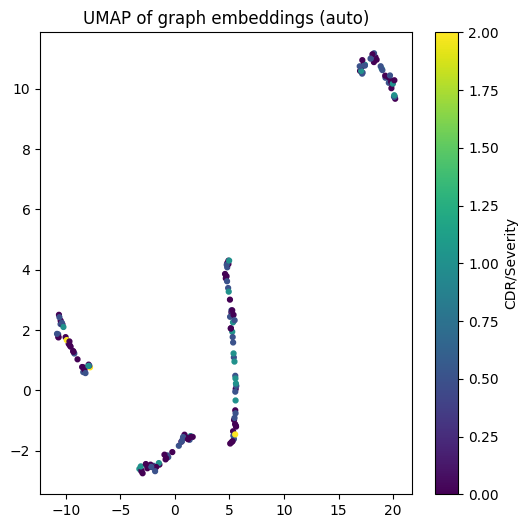

In [ ]:
# Robust graph_to_embedding + recompute embeddings (doesn't require encoder.get_embedding)
import numpy as np, os, torch
from torch_geometric.nn import global_mean_pool
BASE="/content/drive/MyDrive/oasis_project"
FIG_DIR = os.path.join(BASE,"outputs","figures")
os.makedirs(FIG_DIR, exist_ok=True)

encoder.to(device)
encoder.eval()

def try_manual_embed_via_conv_pool(graph, model):
    """If model exposes conv layers (common names: convs, conv_layers, layers) and an embed mlp,
       run node-wise convs -> global_pool -> embed_mlp/classifier split heuristics."""
    x = graph.x.to(device)
    edge_index = getattr(graph, 'edge_index', None)
    batch = getattr(graph, 'batch', None)
    if batch is None:
        batch = torch.zeros(x.size(0), dtype=torch.long, device=device)
    else:
        batch = batch.to(device)

    # try common container names for conv layers
    conv_attrs = ['convs','convs_list','convolution','gnn_layers','layers']
    convs = None
    for a in conv_attrs:
        if hasattr(model, a):
            convs = getattr(model, a)
            break
    # try common embed mlp / pool / classifier names
    embed_attr = None
    for a in ('embed_mlp','embed','mlp','proj','encoder_mlp'):
        if hasattr(model, a):
            embed_attr = getattr(model, a); break
    classifier_attr = None
    for a in ('classifier','fc','head','out_lin','predictor'):
        if hasattr(model, a):
            classifier_attr = getattr(model, a); break

    if convs is None:
        return None  # can't do this strategy

    # apply convs sequentially (duck-typed)
    try:
        h = x
        for conv in convs:
            h = conv(h, edge_index)
            # apply activation if conv has no activation internally
            try:
                import torch.nn.functional as F
                h = F.relu(h)
            except Exception:
                pass
        # pool
        pooled = global_mean_pool(h, batch)
        if embed_attr is not None:
            with torch.no_grad():
                emb = embed_attr(pooled)
            return emb.detach().cpu().numpy().squeeze()
        else:
            # fallback: if classifier exists, try to find its input dim by running a linear slice
            return pooled.detach().cpu().numpy().squeeze()
    except Exception:
        return None

def try_forward_hook_capture(graph, model, hook_on='last_linear'):
    """
    Registers a forward hook on a candidate module and runs a forward pass to capture its output.
    Strategy: find the last nn.Linear (or last nn.Module) and hook it; return its activation.
    """
    import torch.nn as nn
    activ = {}
    # find candidate modules
    last_linear = None
    last_module = None
    for name, mod in model.named_modules():
        last_module = (name, mod)
        if isinstance(mod, nn.Linear):
            last_linear = (name, mod)

    hook_mod = None
    hook_name = None
    if last_linear is not None:
        hook_name, hook_mod = last_linear
    elif last_module is not None:
        hook_name, hook_mod = last_module

    if hook_mod is None:
        return None

    def _hook(module, input, output):
        # store a CPU numpy copy of the activation
        try:
            out = output.detach().cpu().numpy()
        except Exception:
            # sometimes output is tuple
            try:
                out = output[0].detach().cpu().numpy()
            except Exception:
                out = None
        activ['value'] = out

    handle = hook_mod.register_forward_hook(_hook)
    try:
        # run forward pass (graph may be modified by earlier code; ensure batch)
        g = graph
        if not hasattr(g, 'batch') or g.batch is None:
            g.batch = torch.zeros(getattr(g, 'num_nodes', g.x.size(0)), dtype=torch.long)
        # ensure tensors on device
        g = g.to(device)
        with torch.no_grad():
            out = model(g)  # call model normally
        # after forward, activ['value'] should hold intermediate
        val = activ.get('value', None)
        # cleanup handle
        handle.remove()
        if val is None:
            return None
        # If val is per-graph (batch_dim, dim) or (dim,), return squeezes
        return np.array(val).squeeze()
    except Exception as e:
        try:
            handle.remove()
        except:
            pass
        return None

def graph_to_embedding_auto(graph, model):
    # 1) if model has get_embedding, use it
    if hasattr(model, 'get_embedding'):
        try:
            emb = model.get_embedding(graph)  # may return tensor
            if isinstance(emb, torch.Tensor):
                return emb.detach().cpu().numpy().squeeze()
            else:
                return np.array(emb).squeeze()
        except Exception:
            pass

    # 2) If model forward returns a vector (not scalar), use model(graph) directly
    try:
        model.eval()
        with torch.no_grad():
            g = graph
            if not hasattr(g, 'batch') or g.batch is None:
                g.batch = torch.zeros(getattr(g, 'num_nodes', g.x.size(0)), dtype=torch.long)
            out = model(g)
            # if out is tensor and has dim>0 and length>1, use it as embedding
            if isinstance(out, torch.Tensor):
                arr = out.detach().cpu().numpy().squeeze()
                if getattr(arr, 'ndim', 0) >= 1 and np.size(arr) > 1:
                    return arr
            # else fallthrough
    except Exception:
        pass

    # 3) try manual conv->pool->embed heuristics
    try:
        m = try_manual_embed_via_conv_pool(graph, model)
        if m is not None:
            return np.array(m).squeeze()
    except Exception:
        pass

    # 4) try forward-hook capture from last linear/module
    try:
        h = try_forward_hook_capture(graph, model)
        if h is not None:
            return np.array(h).squeeze()
    except Exception:
        pass

    # 5) last resort: pooled raw node features (global mean of x)
    try:
        x = graph.x.cpu().numpy()
        pooled = x.mean(axis=0)
        return pooled.squeeze()
    except Exception:
        return None

# Test on first graph to see which strategy works (prints a short report)
test_g = graphs[0]
emb0 = graph_to_embedding_auto(test_g, encoder)
print("Emb0 preview:", None if emb0 is None else (np.shape(emb0), np.array(emb0).flatten()[:6].tolist()))

# Now compute embeddings for all graphs (like your loop)
embs = []
labels = []
ids = []
failed = []
for i, g in enumerate(graphs):
    try:
        emb = graph_to_embedding_auto(g, encoder)
        if emb is None:
            failed.append((i, "embedding None"))
            continue
        embs.append(np.atleast_1d(emb))
        # labels and ids as before
        labels.append(float(getattr(g, 'y', torch.tensor(float('nan'))).item()) if hasattr(g,'y') else float('nan'))
        ids.append(getattr(g, 'subject_id', f"idx_{i}"))
    except Exception as e:
        failed.append((i, str(e)))
        continue

print("Computed embeddings:", len(embs), "Failed:", len(failed))
if len(embs) == 0:
    raise RuntimeError("No embeddings computed. See failures:", failed[:10])

embs = np.vstack(embs)
print("Final embeddings shape:", embs.shape)

# Save embeddings and UMAP as before
import pandas as pd
df = pd.DataFrame(embs)
df['label'] = labels
df['subject_id'] = ids
out_tsv = os.path.join(BASE,"outputs","figures","embeddings_rich_auto.tsv")
df.to_csv(out_tsv, sep='\t', index=False)
print("Saved embeddings TSV ->", out_tsv)

# UMAP
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embs_scaled = scaler.fit_transform(embs)
import umap, matplotlib.pyplot as plt
proj = umap.UMAP(n_components=2, random_state=42).fit_transform(embs_scaled)
plt.figure(figsize=(6,6))
sc = plt.scatter(proj[:,0], proj[:,1], c=labels if any([not np.isnan(x) for x in labels]) else None, cmap='viridis', s=12)
if any([not np.isnan(x) for x in labels]):
    plt.colorbar(sc, label='CDR/Severity')
plt.title('UMAP of graph embeddings (auto)')
out_png = os.path.join(BASE,"outputs","figures","umap_embeddings_rich_auto.png")
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print("Saved UMAP ->", out_png)
plt.show()


In [ ]:
# === Connectable GNNExplainer runner (for torch_geometric.explain.algorithm.GNNExplainer) ===
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import importlib

# Attempt to import algorithm-based GNNExplainer and config helpers
try:
    alg_mod = importlib.import_module("torch_geometric.explain.algorithm")
    GNNExplainerAlg = getattr(alg_mod, "GNNExplainer")
except Exception as e:
    raise ImportError(f"Could not import torch_geometric.explain.algorithm.GNNExplainer: {e}")

# Import config classes and enums
from torch_geometric.explain import ExplainerConfig, Explanation, ModelConfig
from torch_geometric.explain.config import (
    MaskType,
    ModelMode,
    ModelTaskLevel,
    ModelReturnType,
    ExplanationType,
)

print("[INFO] Using algorithm-style GNNExplainer:", GNNExplainerAlg)

# Paths and outputs
reps = pd.read_csv(os.path.join(BASE, "outputs", "figures", "cluster_representatives_k4.csv"))
out_dir = os.path.join(BASE, "outputs", "figures", "gnnexplainer")
os.makedirs(out_dir, exist_ok=True)

# Put model on device and in eval mode
model = model.to(device)
model.eval()

# Instantiate algorithm explainer (algorithm-specific hyperparams here)
alg = GNNExplainerAlg(epochs=200, lr=0.01)  # adjust lr / epochs if you like

# Heuristic: try to infer whether model is classification vs regression and graph-level vs node-level
# We'll examine model output for the first available graph in `reps` (safe try/catch)
inferred_mode = None
inferred_task_level = None
inferred_return_type = None

# find any graph object to probe (without modifying it)
probe_g = None
for _, row in reps.iterrows():
    subj = row['subject_id']
    probe_g = next((gg for gg in graphs if getattr(gg, 'subject_id', None) == subj), None)
    if probe_g is not None:
        break

if probe_g is None:
    raise RuntimeError("No representative graph found in `graphs` matching cluster_representatives_k4.csv")

# prepare a CPU copy of probe graph (to avoid moving user's tensors unnecessarily)
probe = probe_g.clone() if hasattr(probe_g, 'clone') else probe_g
probe = probe.cpu()
if not hasattr(probe, 'batch') or probe.batch is None:
    probe.batch = torch.zeros(probe.x.size(0), dtype=torch.long)

# Try a forward pass to infer shape/semantics
try:
    model_cpu = model.to('cpu')
    with torch.no_grad():
        # Many models accept (x, edge_index, batch) and return logits of shape [batch_size, C] for graph-level
        # or [num_nodes, C] for node-level. Try both.
        try:
            out = model_cpu(probe.x, probe.edge_index, probe.batch)
        except TypeError:
            # try (x, edge_index)
            out = model_cpu(probe.x, probe.edge_index)
    # restore model to device
    model = model.to(device)
    # analyze output
    if isinstance(out, (tuple, list)):
        out = out[0]
    if out is None:
        inferred_mode = "multiclass_classification"
        inferred_return_type = "raw"
        inferred_task_level = "graph"
    else:
        # if output has shape [N_nodes, C] and N_nodes == probe.x.shape[0] -> node-level
        if out.dim() >= 2 and out.shape[0] == probe.x.shape[0]:
            inferred_task_level = "node"
        # if output has shape [batch_size, C] where batch_size == number of graphs in batch (maybe 1)
        elif out.dim() >= 2 and out.shape[0] == (probe.batch.max().item() + 1 if probe.batch.numel() else 1):
            inferred_task_level = "graph"
        else:
            # fallback to graph-level
            inferred_task_level = "graph"

        # binary vs multiclass vs regression:
        if out.dim() == 1 or (out.dim() == 2 and out.shape[1] == 1):
            # single scalar -> regression or binary; assume regression unless labels are {0,1}
            inferred_mode = "regression"
            inferred_return_type = "raw"
        else:
            # >1 output dims -> multiclass classification
            inferred_mode = "multiclass_classification"
            inferred_return_type = "raw"
except Exception as e:
    # If probing failed, choose reasonable defaults for graph-level classification
    print("[WARN] Could not probe model output shape for automatic inference:", e)
    inferred_mode = inferred_mode or "multiclass_classification"
    inferred_task_level = inferred_task_level or "graph"
    inferred_return_type = inferred_return_type or "raw"
    # ensure model moved back to device
    model = model.to(device)

print(f"[INFO] Inferred model_config: mode={inferred_mode}, task_level={inferred_task_level}, return_type={inferred_return_type}")

# Build ExplainerConfig and ModelConfig with ENUMs when possible (safer than strings)
# We'll try to use enum members; if that fails (API differences), we fall back to passing strings.
try:
    expl_cfg = ExplainerConfig(
        explanation_type=ExplanationType("model"),           # ExplanationType enum accepts "model"
        node_mask_type=MaskType("object"),                   # mask nodes individually
        edge_mask_type=MaskType("object"),                   # mask edges
    )
    model_cfg = ModelConfig(
        mode=ModelMode(inferred_mode),
        task_level=ModelTaskLevel(inferred_task_level),
        return_type=ModelReturnType(inferred_return_type),
    )
except Exception as e:
    # Some installs require different enum member creation; fall back to string-based construction
    print("[WARN] Enum construction failed (falling back to string-based config):", e)
    expl_cfg = ExplainerConfig(
        explanation_type="model",
        node_mask_type="object",
        edge_mask_type="object",
    )
    model_cfg = ModelConfig(
        mode=inferred_mode,
        task_level=inferred_task_level,
        return_type=inferred_return_type,
    )

# Connect configurations to algorithm explainer
try:
    alg.connect(explainer_config=expl_cfg, model_config=model_cfg)
    print("[INFO] alg.connect(...) succeeded.")
except Exception as e:
    raise RuntimeError(f"alg.connect(...) failed: {e}")

# Helper to call the algorithm explain method robustly
def call_algorithm_explain(algorithm, x, edge_index, batch=None, target=None, index=None):
    """
    Try several common call forms for algorithm-based explainers.
    Returns an Explanation object or (node_mask, edge_mask) tuple.
    """
    # try common method names: explain_graph, explain, __call__
    for mname in ("explain_graph", "explain", "__call__", "forward"):
        if hasattr(algorithm, mname):
            m = getattr(algorithm, mname)
            # try variations of args
            # 1) (x, edge_index)
            try:
                return m(x, edge_index)
            except Exception:
                pass
            # 2) (x, edge_index, None)
            try:
                return m(x, edge_index, None)
            except Exception:
                pass
            # 3) (x, edge_index, target=target) or (x, edge_index, index=index)
            try:
                return m(x=x, edge_index=edge_index, batch=batch, target=target, index=index)
            except Exception:
                pass
            # 4) (model, x, edge_index)
            try:
                return m(algorithm.model if hasattr(algorithm, 'model') else model, x, edge_index)
            except Exception:
                pass
    # if nothing worked, raise
    raise RuntimeError("No supported explain call signature found on algorithm.")

# Main explanation loop (saves masks + overlays)
for idx, row in tqdm(reps.iterrows(), total=len(reps), desc="Explaining graphs"):
    subj = row['subject_id']
    g = next((gg for gg in graphs if getattr(gg, 'subject_id', None) == subj), None)
    if g is None:
        print("[WARN] Missing graph for", subj)
        continue

    # ensure batch attr
    if not hasattr(g, 'batch') or g.batch is None:
        g.batch = torch.zeros(g.x.size(0), dtype=torch.long)

    # keep a CPU copy for plotting/saving purposes
    g_cpu = g.cpu()

    # move graph to device
    g_dev = g.to(device)

    # call the algorithm's explain function
    try:
        result = call_algorithm_explain(alg, g_dev.x, g_dev.edge_index, batch=g_dev.batch)
    except Exception as e:
        print(f"[ERROR] algorithm explain call failed for {subj}: {e}")
        # print some helpful debugging information
        callable_attrs = [a for a in dir(alg) if callable(getattr(alg, a)) and not a.startswith('_')]
        print("[DEBUG] Callable attrs on alg (sample):", callable_attrs[:40])
        continue

    # parse result
    node_mask = None
    edge_mask = None
    if isinstance(result, tuple):
        # common case: (node_mask, edge_mask)
        if len(result) >= 1:
            node_mask = result[0]
        if len(result) >= 2:
            edge_mask = result[1]
    else:
        # likely an Explanation object
        node_mask = getattr(result, 'node_mask', None) or getattr(result, 'node_imp', None)
        edge_mask = getattr(result, 'edge_mask', None) or getattr(result, 'edge_imp', None)

    if node_mask is None:
        print(f"[WARN] No node_mask returned for {subj}; skipping.")
        continue

    # convert to numpy arrays
    if isinstance(node_mask, torch.Tensor):
        node_imp = node_mask.detach().cpu().numpy()
    else:
        node_imp = np.asarray(node_mask)

    if edge_mask is not None:
        if isinstance(edge_mask, torch.Tensor):
            edge_imp = edge_mask.detach().cpu().numpy()
        else:
            edge_imp = np.asarray(edge_mask)
    else:
        # default to zero-length or zeros if we know edge count
        try:
            edge_count = g_cpu.edge_index.shape[1]
            edge_imp = np.zeros((edge_count,), dtype=float)
        except Exception:
            edge_imp = np.array([])

    # save masks (npy + csv)
    np.save(os.path.join(out_dir, f"{subj}_gnnexplainer_node_mask.npy"), node_imp)
    np.save(os.path.join(out_dir, f"{subj}_gnnexplainer_edge_mask.npy"), edge_imp)
    pd.DataFrame({"node_idx": np.arange(len(node_imp)), "importance": node_imp}).to_csv(
        os.path.join(out_dir, f"{subj}_gnnexplainer_node_mask.csv"), index=False)
    pd.DataFrame({"edge_idx": np.arange(len(edge_imp)), "importance": edge_imp}).to_csv(
        os.path.join(out_dir, f"{subj}_gnnexplainer_edge_mask.csv"), index=False)

    # overlay scatter plot (prefer g.pos, else PCA on features)
    try:
        if hasattr(g_cpu, 'pos') and g_cpu.pos is not None:
            coords = g_cpu.pos.detach().cpu().numpy()
        else:
            coords = PCA(n_components=3).fit_transform(g_cpu.x.detach().cpu().numpy())
    except Exception:
        coords = PCA(n_components=3).fit_transform(g_dev.x.detach().cpu().numpy())

    if coords.shape[1] < 3:
        coords = np.pad(coords, ((0, 0), (0, 3 - coords.shape[1])), mode='constant')

    z_slice = int(np.round(coords[:, 2].mean()))
    sel = np.abs(coords[:, 2] - z_slice) < 8
    if np.sum(sel) == 0:
        sel = np.ones(coords.shape[0], dtype=bool)

    imp_sel = node_imp[sel]
    max_imp = float(np.max(imp_sel)) if imp_sel.size else 0.0
    size_factor = 50.0
    marker_sizes = size_factor * (imp_sel / (max_imp + 1e-9) + 0.01)

    plt.figure(figsize=(6, 6))
    sc = plt.scatter(coords[sel, 0], coords[sel, 1], s=marker_sizes, c=imp_sel)
    plt.colorbar(sc, label='node importance (GNNExplainer)')
    plt.title(f'GNNExplainer overlay {subj} (approx z={z_slice})')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{subj}_gnnexplainer_overlay.png"), dpi=150)
    plt.close()

print("Done. Outputs saved to:", out_dir)


[INFO] Using algorithm-style GNNExplainer: <class 'torch_geometric.explain.algorithm.gnn_explainer.GNNExplainer'>
[INFO] Inferred model_config: mode=regression, task_level=graph, return_type=raw
[INFO] alg.connect(...) succeeded.


Explaining graphs: 100%|██████████| 16/16 [00:00<00:00, 896.08it/s]

[ERROR] algorithm explain call failed for graph_0119_subj_119: No supported explain call signature found on algorithm.
[DEBUG] Callable attrs on alg (sample): ['add_module', 'apply', 'bfloat16', 'buffers', 'children', 'compile', 'connect', 'cpu', 'cuda', 'double', 'eval', 'extra_repr', 'float', 'forward', 'get_buffer', 'get_extra_state', 'get_parameter', 'get_submodule', 'half', 'ipu', 'load_state_dict', 'modules', 'mtia', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_full_backward_pre_hook', 'register_load_state_dict_post_hook', 'register_load_state_dict_pre_hook', 'register_module', 'register_parameter', 'register_state_dict_post_hook', 'register_state_dict_pre_hook']
[ERROR] algorithm explain call failed for graph_0118_subj_118: No supported explain call signature found on algorithm.
[DEBUG] Callable attrs

In [ ]:
# Install captum robustly in a notebook (try no-deps first to avoid numpy conflicts)
import importlib, sys, subprocess

def install_captum():
    try:
        # Quick import check
        mod = importlib.import_module('captum.attr')
        print("[OK] captum is already installed.")
        return True
    except Exception:
        pass

    print("[INFO] captum not found. Installing with --no-deps to avoid changing numpy/opencv etc.")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "captum", "--no-deps"])
        importlib.invalidate_caches()
        import captum.attr  # try import again
        print("[OK] captum installed (no-deps).")
        return True
    except Exception as e_no_deps:
        print("[WARN] install with --no-deps failed or import still failed:", e_no_deps)
        print("[INFO] Trying a normal pip install captum (this may upgrade dependencies).")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "captum"])
            importlib.invalidate_caches()
            import captum.attr
            print("[OK] captum installed.")
            return True
        except Exception as e_full:
            print("[ERROR] Full pip install failed or import still failed:", e_full)
            return False

ok = install_captum()
if not ok:
    print()
    print("If you still see errors, you likely need a compatible PyTorch build for Captum.")
    print("Check your torch version inside Python:")
    print("    import torch; print(torch.__version__); print(torch.cuda.is_available())")
    print()
    print("If torch is missing or incompatible, install a matching torch wheel first. Examples (pick the one matching your CUDA):")
    print("  # CPU-only:")
    print("  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu")
    print("  # CUDA 11.8 (example):")
    print("  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
    print()
    print("Then re-run this cell to install captum (without --no-deps or with --no-deps if you prefer).")


[INFO] captum not found. Installing with --no-deps to avoid changing numpy/opencv etc.
[OK] captum installed (no-deps).


In [ ]:
# Diagnostic + robust Captum IG runner with auto-fixes for crazy edge_index shapes
import importlib, sys, os, numpy as np, pandas as pd, torch
from tqdm import tqdm

try:
    from captum.attr import IntegratedGradients
except Exception:
    print("[ERROR] captum not available. Install captum and re-run.")
    raise

# --- helper repairs & diagnostics ---
def try_convert_dense_adj_to_edge_index(adj):
    """
    If adj is a dense adjacency matrix (NxN), convert nonzero to COO edge_index [2, E]
    """
    if isinstance(adj, np.ndarray):
        adj_t = torch.from_numpy(adj)
    else:
        adj_t = adj
    if adj_t.dim() == 2 and adj_t.size(0) == adj_t.size(1):
        nz = (adj_t != 0).nonzero(as_tuple=False).t()
        return nz.contiguous()
    return None

def robust_extract_edge_index(candidate, x=None):
    """
    Take a candidate edge_index-like object and try to return a proper torch.LongTensor shaped [2,E].
    Tries many fallbacks and logs what it did (returns (edge_index, log_message)).
    """
    msg = []
    ei = candidate

    # If it's a tuple/list, try to locate the element that looks like an edge_index
    if isinstance(ei, (tuple, list)):
        msg.append(f"candidate is tuple/list of len={len(ei)}; trying elements")
        for k, el in enumerate(ei):
            try:
                candidate_el = torch.as_tensor(el)
            except Exception:
                continue
            # if this element looks like [2, E], choose it
            if candidate_el.dim() == 2 and candidate_el.size(0) == 2:
                msg.append(f"selected element {k} as edge_index (shape {tuple(candidate_el.shape)})")
                return candidate_el.long().contiguous(), "; ".join(msg)
        # fallback: pick first element
        try:
            first = torch.as_tensor(ei[0])
            msg.append("no explicit [2,E] element found; using first element")
            ei = first
        except Exception:
            msg.append("could not convert tuple/list elements to tensor")
            return None, "; ".join(msg)

    # If numpy -> tensor
    if isinstance(ei, np.ndarray):
        ei = torch.from_numpy(ei)

    if not torch.is_tensor(ei):
        try:
            ei = torch.tensor(ei)
            msg.append("converted to tensor via torch.tensor()")
        except Exception as e:
            msg.append(f"cannot convert candidate to tensor: {e}")
            return None, "; ".join(msg)

    # Now ei is a tensor
    if ei.dim() != 2:
        msg.append(f"tensor has dim={ei.dim()} (expected 2)")
        # try to reshape if possible
        if ei.numel() % 2 == 0:
            maybe = ei.view(2, -1)
            if maybe.size(0) == 2:
                msg.append(f"reshaped flattened array to (2, {maybe.size(1)})")
                return maybe.long().contiguous(), "; ".join(msg)
        # try dense adj conversion if square matrix
        try:
            conv = try_convert_dense_adj_to_edge_index(ei)
            if conv is not None:
                msg.append("converted square dense adjacency to COO edge_index")
                return conv.long().contiguous(), "; ".join(msg)
        except Exception:
            pass
        return None, "; ".join(msg)

    # if shape is (E, 2) -> transpose
    if ei.size(0) != 2 and ei.size(1) == 2:
        msg.append(f"edge_index looks like (E,2) with shape {tuple(ei.shape)}; transposing")
        ei = ei.t().contiguous()
        return ei.long(), "; ".join(msg)

    # if it's already (2, E) return
    if ei.size(0) == 2:
        msg.append(f"edge_index already (2, E) with shape {tuple(ei.shape)}")
        return ei.long().contiguous(), "; ".join(msg)

    # if neither dim is 2 but it's square NxN adjacency
    if ei.size(0) == ei.size(1):
        nz = (ei != 0).nonzero(as_tuple=False).t()
        msg.append("candidate is square matrix; converted to COO edge_index via nonzero()")
        return nz.long().contiguous(), "; ".join(msg)

    # last resort: check if number of elements equals 2 * some integer
    if ei.numel() % 2 == 0:
        maybe = ei.view(2, -1)
        msg.append(f"last-resort reshape to (2, {maybe.size(1)}) from flattened array")
        return maybe.long().contiguous(), "; ".join(msg)

    msg.append(f"unable to coerce candidate shape {tuple(ei.shape)} to (2,E)")
    return None, "; ".join(msg)

def ensure_edge_index_pretty(ei, x=None):
    """
    Wrapper: try robust_extract_edge_index and return (edge_index_tensor, action_msg).
    """
    try:
        ei_fixed, msg = robust_extract_edge_index(ei, x=x)
        return ei_fixed, msg
    except Exception as e:
        return None, f"exception during extract: {e}"

# --- Captum forward wrapper with robust edge_index fixing ---
def make_forward_fn_with_repair(model):
    def forward_fn(x_batch, edge_index_arg, batch_arg):
        # x_batch [1, N, F] -> squeeze
        x = x_batch.squeeze(0)
        dev = next(model.parameters()).device

        # Try to repair edge_index first
        ei_candidate = edge_index_arg
        ei_fixed, msg = ensure_edge_index_pretty(ei_candidate, x)
        if ei_fixed is None:
            # try common fallback: maybe edge_index_arg is tuple (edge_index, edge_attr)
            if isinstance(edge_index_arg, (tuple, list)) and len(edge_index_arg) > 0:
                # try element 0
                ei_fixed, msg2 = ensure_edge_index_pretty(edge_index_arg[0], x)
                msg += "; fallback0: " + msg2
        if ei_fixed is None:
            # nothing worked — raise with detailed info
            raise ValueError(f"Failed to coerce edge_index to shape [2,E]. debug: {msg}; "
                             f"type(edge_index_arg)={type(edge_index_arg)}, shape_info={getattr(edge_index_arg, 'shape', None)}")

        # move to device and set long
        edge_index = ei_fixed.to(dev).long()

        # prepare batch tensor correctly
        if batch_arg is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=dev)
        else:
            batch = torch.as_tensor(batch_arg).to(dev)
            if batch.dim() > 1:
                batch = batch.view(-1)
            if batch.numel() == 1:
                batch = batch.expand(x.size(0))
            if batch.numel() != x.size(0):
                # last-resort correction: set single-graph batch
                batch = torch.zeros(x.size(0), dtype=torch.long, device=dev)

        x = x.to(dev)

        # Call model; try common signatures
        try:
            out = model(x, edge_index, batch)
        except TypeError:
            try:
                out = model(x, edge_index)
            except TypeError:
                try:
                    DataObj = type('D', (), {})
                    d = DataObj()
                    d.x = x
                    d.edge_index = edge_index
                    d.batch = batch
                    out = model(d)
                except Exception as e:
                    raise RuntimeError(f"Model forward failed for signatures (x,edge_index,batch)/(x,edge_index)/Data: {e}")

        if isinstance(out, (tuple, list)):
            out = out[0]
        if out.dim() == 1:
            out = out.unsqueeze(0)
        return out
    return forward_fn

# === Main runner using the repaired wrapper ===
def run_captum_with_repair(model, graphs, reps_df, out_dir,
                           baseline_value=0.0, steps=40, target_mode='predicted'):
    os.makedirs(out_dir, exist_ok=True)
    model = model.to(next(model.parameters()).device)
    model.eval()

    forward_fn = make_forward_fn_with_repair(model)
    ig = IntegratedGradients(forward_fn, multiply_by_inputs=False)

    for subj in tqdm(reps_df['subject_id'].tolist(), desc="IG per graph (repair)"):
        g = next((gg for gg in graphs if getattr(gg,'subject_id',None)==subj), None)
        if g is None:
            print(f"[WARN] missing graph for {subj}; skipping")
            continue

        if not hasattr(g, 'batch') or g.batch is None:
            g.batch = torch.zeros(g.x.size(0), dtype=torch.long)

        # keep CPU copy for debug & plotting
        g_cpu = g.cpu()

        # prepare inputs
        dev = next(model.parameters()).device
        g_dev = g.to(dev)

        inputs = g_dev.x.unsqueeze(0).detach().requires_grad_(True)

        # attempt to coerce edge_index with verbose feedback
        try:
            ei_fixed, ei_msg = ensure_edge_index_pretty(g_dev.edge_index, g_dev.x)
            if ei_fixed is None:
                # try tuple/list fallback
                if isinstance(g_dev.edge_index, (tuple, list)) and len(g_dev.edge_index) > 0:
                    ei_fixed, ei_msg2 = ensure_edge_index_pretty(g_dev.edge_index[0], g_dev.x)
                    ei_msg += "; fallback0: " + ei_msg2
            if ei_fixed is None:
                print(f"[ERROR][{subj}] Could not coerce edge_index: {ei_msg}; original shape/type: {type(g_dev.edge_index)}, {getattr(g_dev.edge_index, 'shape', None)}")
                # still attempt IG; forward wrapper will raise with details
            else:
                # show message for debugging
                print(f"[INFO][{subj}] edge_index repaired: {ei_msg}; final_shape={tuple(ei_fixed.shape)}")
        except Exception as e:
            print(f"[ERROR][{subj}] ensure_edge_index_pretty exception: {e}")

        batch_const = g_dev.batch
        if not torch.is_tensor(batch_const):
            batch_const = torch.tensor(batch_const, dtype=torch.long, device=dev)
        else:
            batch_const = batch_const.to(dev)
            if batch_const.dim() > 1:
                batch_const = batch_const.view(-1)
            if batch_const.numel() == 1:
                batch_const = batch_const.expand(g_dev.x.size(0))

        # determine target
        try:
            with torch.no_grad():
                # use forward wrapper for a consistent forward
                out = forward_fn(inputs, g_dev.edge_index, batch_const)
            if out.dim()==2 and out.shape[1]>1:
                target_idx = int(out.argmax(dim=1).item())
            else:
                target_idx = 0
        except Exception as e:
            print(f"[WARN][{subj}] forward probing failed when choosing target: {e}; defaulting target=0")
            target_idx = 0

        baseline = torch.full_like(inputs, baseline_value)

        # run IG after all repairs
        try:
            attributions, delta = ig.attribute(inputs=inputs,
                                               additional_forward_args=(g_dev.edge_index, batch_const),
                                               baselines=baseline,
                                               target=target_idx,
                                               n_steps=steps,
                                               return_convergence_delta=True)
        except Exception as e:
            # very verbose debug on failure
            print(f"[ERROR][{subj}] Captum IG failed after repair: {e}")
            try:
                print("  inputs.shape:", inputs.shape)
                print("  edge_index.type/shape:", type(g_dev.edge_index), getattr(g_dev.edge_index, 'shape', None))
                print("  batch.shape:", tuple(batch_const.shape))
            except Exception:
                pass
            continue

        node_attr = attributions.squeeze(0).abs().sum(dim=1).detach().cpu().numpy()

        # save
        np.save(os.path.join(out_dir, f"{subj}_captum_ig_node_attr.npy"), node_attr)
        pd.DataFrame({"node_idx": np.arange(len(node_attr)), "importance": node_attr}).to_csv(
            os.path.join(out_dir, f"{subj}_captum_ig_node_attr.csv"), index=False)

    print("Done. Saved to:", out_dir)

# === Run the repaired IG run ===
out_dir = os.path.join(BASE, "outputs", "figures", "captum_ig_repair")
run_captum_with_repair(model=model, graphs=graphs, reps_df=reps, out_dir=out_dir,
                      baseline_value=0.0, steps=40, target_mode='predicted')


IG per graph (repair):   6%|▋         | 1/16 [00:00<00:02,  6.24it/s]

[INFO][graph_0119_subj_119] edge_index repaired: edge_index already (2, E) with shape (2, 22106); final_shape=(2, 22106)
[ERROR][graph_0119_subj_119] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 22106])
  batch.shape: (1575,)
[INFO][graph_0118_subj_118] edge_index repaired: edge_index already (2, E) with shape (2, 21946); final_shape=(2, 21946)


IG per graph (repair):  19%|█▉        | 3/16 [00:00<00:01,  9.87it/s]

[ERROR][graph_0118_subj_118] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 21946])
  batch.shape: (1575,)
[INFO][graph_0175_subj_175] edge_index repaired: edge_index already (2, E) with shape (2, 22248); final_shape=(2, 22248)
[ERROR][graph_0175_subj_175] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 22248])
  batch.shape: (1575,)
[INFO][graph_0104_subj_104] edge_index repaired: edge_index already (2, E) with shape (2, 22128); final_shape=(2, 22128)
[ERROR][graph_0104_subj_104] Captum IG faile

IG per graph (repair):  44%|████▍     | 7/16 [00:00<00:00, 12.96it/s]

[ERROR][graph_0117_subj_117] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 21238])
  batch.shape: (1575,)
[INFO][graph_0032_subj_32] edge_index repaired: edge_index already (2, E) with shape (2, 21440); final_shape=(2, 21440)
[ERROR][graph_0032_subj_32] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 21440])
  batch.shape: (1575,)
[INFO][graph_0028_subj_28] edge_index repaired: edge_index already (2, E) with shape (2, 21356); final_shape=(2, 21356)
[ERROR][graph_0028_subj_28] Captum IG failed af

IG per graph (repair):  56%|█████▋    | 9/16 [00:00<00:00, 13.48it/s]

[ERROR][graph_0075_subj_75] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 21652])
  batch.shape: (1575,)
[INFO][graph_0055_subj_55] edge_index repaired: edge_index already (2, E) with shape (2, 22436); final_shape=(2, 22436)
[ERROR][graph_0055_subj_55] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 22436])
  batch.shape: (1575,)
[INFO][graph_0121_subj_121] edge_index repaired: edge_index already (2, E) with shape (2, 22010); final_shape=(2, 22010)
[ERROR][graph_0121_subj_121] Captum IG failed a

IG per graph (repair):  81%|████████▏ | 13/16 [00:01<00:00, 14.00it/s]

[ERROR][graph_0183_subj_183] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 21936])
  batch.shape: (1575,)
[INFO][graph_0120_subj_120] edge_index repaired: edge_index already (2, E) with shape (2, 22146); final_shape=(2, 22146)
[ERROR][graph_0120_subj_120] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 22146])
  batch.shape: (1575,)
[INFO][graph_0053_subj_53] edge_index repaired: edge_index already (2, E) with shape (2, 22304); final_shape=(2, 22304)
[ERROR][graph_0053_subj_53] Captum IG failed 

IG per graph (repair): 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]

[ERROR][graph_0127_subj_127] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 22250])
  batch.shape: (1575,)
[INFO][graph_0021_subj_21] edge_index repaired: edge_index already (2, E) with shape (2, 22018); final_shape=(2, 22018)
[ERROR][graph_0021_subj_21] Captum IG failed after repair: The expanded size of the tensor (1575) must match the existing size (40) at non-singleton dimension 1.  Target sizes: [40, 1575, 128].  Tensor sizes: [1, 40, 1]
  inputs.shape: torch.Size([1, 1575, 50])
  edge_index.type/shape: <class 'torch.Tensor'> torch.Size([2, 22018])
  batch.shape: (1575,)
[INFO][graph_0051_subj_51] edge_index repaired: edge_index already (2, E) with shape (2, 21978); final_shape=(2, 21978)
[ERROR][graph_0051_subj_51] Captum IG failed af

In [ ]:
# One-shot helper: copy rep PNGs, create canonical .npy from rep CSVs, inspect graph npz folders
import os, glob, shutil, numpy as np, pandas as pd

BASE = os.environ.get("BASE", "/content/drive/MyDrive/oasis_project")  # adjust if needed

# 1) copy rep PNG overlays (fast visual fallback)
src_pattern = os.path.join(BASE, "outputs", "figures", "rep_graph_*_node_imp_overlay*.png")
dst_dir = os.path.join(BASE, "outputs", "figures", "nifti_overlays")
os.makedirs(dst_dir, exist_ok=True)

copied = []
for p in glob.glob(src_pattern):
    try:
        shutil.copy(p, dst_dir)
        copied.append(os.path.basename(p))
    except Exception as e:
        print("Copy error for", p, ":", e)

# 2) convert rep CSV importance -> canonical .npy names
csv_pattern = os.path.join(BASE, "outputs", "figures", "rep_graph_*_node_importance*.csv")
out_npy_dir = os.path.join(BASE, "outputs", "figures", "gnnexplainer")
os.makedirs(out_npy_dir, exist_ok=True)

converted = []
for csvf in glob.glob(csv_pattern):
    try:
        df = pd.read_csv(csvf)
        # pick sensible column
        col = None
        for candidate in ['importance','value','node_imp','node_importance','importance_value']:
            if candidate in df.columns:
                col = candidate; break
        if col is None:
            # fallback: second column if first is node index
            if df.shape[1] >= 2:
                col = df.columns[1]
            else:
                col = df.columns[0]
        arr = np.asarray(df[col].to_numpy()).ravel()
        # build name: find graph_xxx substring
        base = os.path.basename(csvf)
        import re
        m = re.search(r"(graph_\d+_subj_\d+)", base)
        name = m.group(1) if m else os.path.splitext(base)[0]
        outp = os.path.join(out_npy_dir, f"{name}_gnnexplainer_node_mask.npy")
        np.save(outp, arr)
        converted.append((csvf, outp, arr.size))
    except Exception as e:
        print("Failed to convert", csvf, ":", e)

# 3) inspect npz graph directories user mentioned
npz_dirs = [
    os.path.join(BASE, "data", "graphs", "npz_graphs"),
    os.path.join(BASE, "data", "graphs", "npz_graphs_resave"),
    os.path.join(BASE, "data", "graphs", "labeled_npz_full"),
]
npz_summary = {}
for d in npz_dirs:
    files = sorted(glob.glob(os.path.join(d, "*.npz")))
    npz_summary[d] = {"count": len(files), "examples": []}
    for f in files[:5]:
        try:
            with np.load(f, allow_pickle=True) as z:
                keys = list(z.keys())
                # show small sample of keys and shapes/types
                key_info = {}
                for k in keys:
                    try:
                        val = z[k]
                        key_info[k] = (np.asarray(val).shape, type(val))
                    except Exception:
                        key_info[k] = ("<unreadable>", type(z[k]))
                npz_summary[d]["examples"].append({"file": os.path.basename(f), "keys": key_info})
        except Exception as e:
            npz_summary[d]["examples"].append({"file": os.path.basename(f), "error": str(e)})

# 4) print summary
print("=== Copied rep PNGs into nifti_overlays ===")
if copied:
    print("Copied", len(copied), "files. Examples:", copied[:8])
else:
    print("No rep PNGs found to copy (pattern: {})".format(src_pattern))

print("\n=== Converted CSV -> NPY ===")
if converted:
    for src, dst, ln in converted[:10]:
        print("Converted", os.path.basename(src), "->", os.path.basename(dst), " (len=", ln, ")")
else:
    print("No rep CSVs found (pattern: {})".format(csv_pattern))

print("\n=== NPZ graph folders inspection ===")
for d, info in npz_summary.items():
    print(f"Folder: {d}  (npz count = {info['count']})")
    for ex in info['examples']:
        if 'error' in ex:
            print("  ", ex['file'], " - ERROR reading:", ex['error'])
        else:
            print("  ", ex['file'], " keys:")
            for k, v in ex['keys'].items():
                print("     ", k, "->", v)
    print("  ---")

print("\nNext steps (pick one):")
print("  1) If you want anatomical overlays on NIfTI slices, run:")
print("       import glob; print('\\n'.join(glob.glob(os.path.join(BASE, '**', '*.nii*'), recursive=True)))")
print("     then paste the output here and I will auto-match NIfTIs to subjects and create overlays.")
print("  2) If you're happy with the rep PNGs copied to nifti_overlays, open that folder to inspect them.")
print("  3) I can now run the overlay routine (world->voxel conversion) if you paste the path(s) of the T1 NIfTIs or confirm they exist under BASE/data/preproc.")


=== Copied rep PNGs into nifti_overlays ===
Copied 16 files. Examples: ['rep_graph_0119_subj_119_node_imp_overlay_gradient.png', 'rep_graph_0118_subj_118_node_imp_overlay_gradient.png', 'rep_graph_0175_subj_175_node_imp_overlay_gradient.png', 'rep_graph_0104_subj_104_node_imp_overlay_gradient.png', 'rep_graph_0117_subj_117_node_imp_overlay_gradient.png', 'rep_graph_0032_subj_32_node_imp_overlay_gradient.png', 'rep_graph_0028_subj_28_node_imp_overlay_gradient.png', 'rep_graph_0075_subj_75_node_imp_overlay_gradient.png']

=== Converted CSV -> NPY ===
Converted rep_graph_0119_subj_119_node_importance_explainer_gradient.csv -> graph_0119_subj_119_gnnexplainer_node_mask.npy  (len= 1575 )
Converted rep_graph_0119_subj_119_node_importance_gradient.csv -> graph_0119_subj_119_gnnexplainer_node_mask.npy  (len= 1575 )
Converted rep_graph_0118_subj_118_node_importance_gradient.csv -> graph_0118_subj_118_gnnexplainer_node_mask.npy  (len= 1575 )
Converted rep_graph_0175_subj_175_node_importance_grad

Auto-generated pos_clean for 627 NPZs (examples): ['/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0000_subj_0_pos_clean.npy', '/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0001_subj_1_pos_clean.npy', '/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0002_subj_2_pos_clean.npy', '/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0003_subj_3_pos_clean.npy', '/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0004_subj_4_pos_clean.npy', '/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0005_subj_5_pos_clean.npy']
Found 305 NIfTI files under BASE.
Created overlay: /content/drive/MyDrive/oasis_project/outputs/figures/nifti_overlays/graph_0032_subj_32_nifti_overlay_z0_pca.png
Created overlay: /content/drive/MyDrive/oasis_project/outputs/figures/nifti_overlays/graph_0028_subj_28_nifti_overlay_z0_pca.png
Created overlay: /content/drive/MyDrive/oasis_project/outputs/figures/nifti_overlays/gr

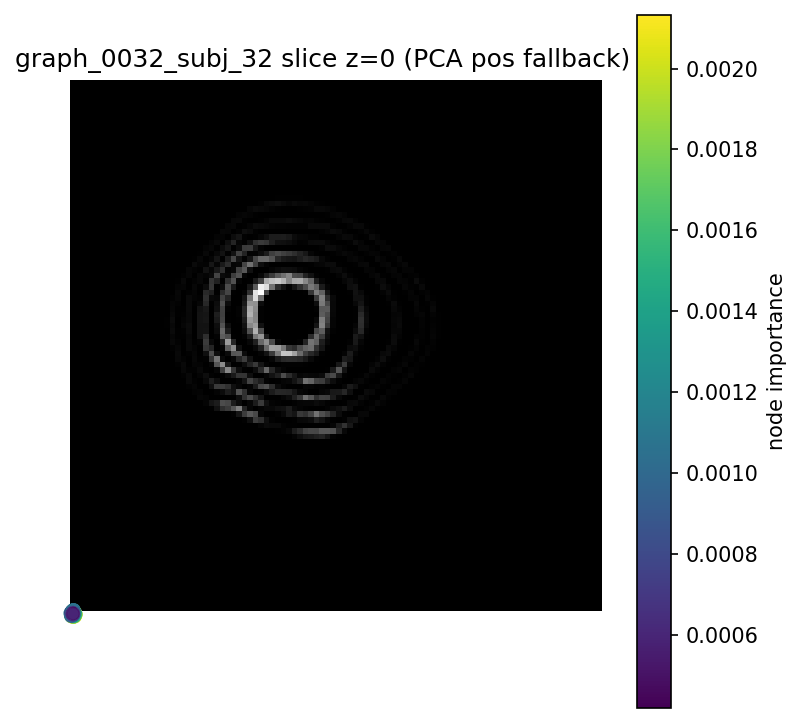

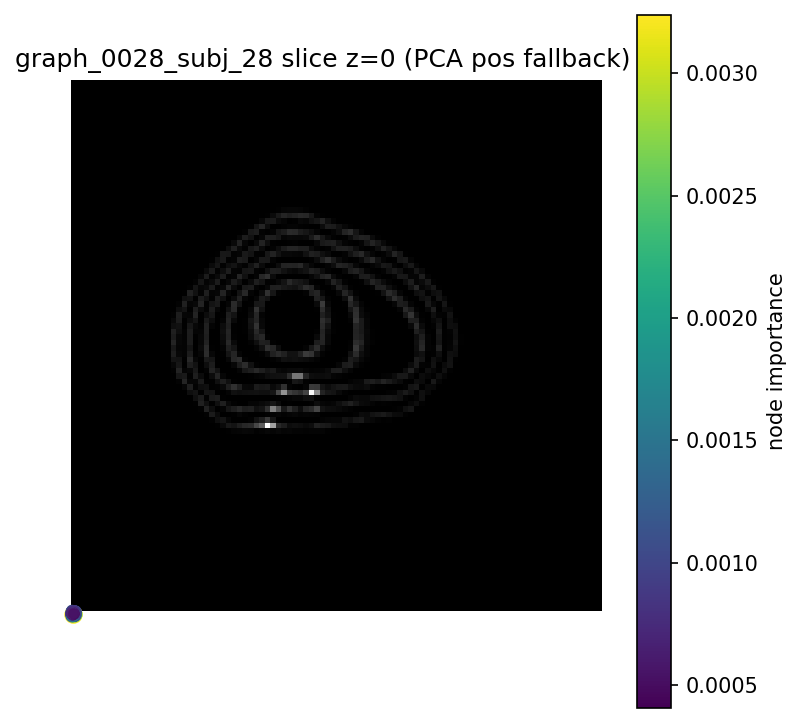

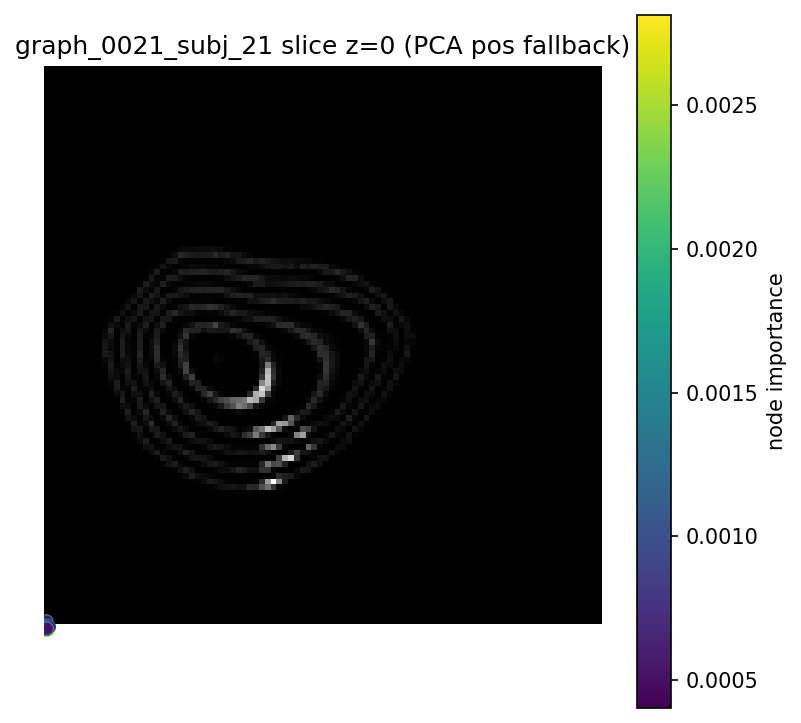

Some failures examples: [('graph_0119_subj_119', 'no_nifti'), ('graph_0118_subj_118', 'no_nifti'), ('graph_0175_subj_175', 'no_nifti'), ('graph_0104_subj_104', 'no_nifti'), ('graph_0117_subj_117', 'no_nifti'), ('graph_0075_subj_75', 'no_nifti'), ('graph_0055_subj_55', 'no_nifti'), ('graph_0121_subj_121', 'no_nifti')]


In [ ]:
# Auto-generate pos via PCA for NPZs with missing pos, then create NIfTI overlays
import os, glob, re, numpy as np, pandas as pd, nibabel as nib, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, Image

BASE = os.environ.get("BASE", "/content/drive/MyDrive/oasis_project")
OUT_DIR = os.path.join(BASE, "outputs", "figures", "nifti_overlays")
GNN_DIR = os.path.join(BASE, "outputs", "figures", "gnnexplainer")
NPZ_DIRS = [
    os.path.join(BASE, "data", "graphs", "npz_graphs"),
    os.path.join(BASE, "data", "graphs", "npz_graphs_resave"),
    os.path.join(BASE, "data", "graphs", "labeled_npz_full"),
]
os.makedirs(OUT_DIR, exist_ok=True)

# === helper funcs ===
def find_all_niftis(base):
    return sorted(set(glob.glob(os.path.join(base, "**", "*.nii.gz"), recursive=True) +
                      glob.glob(os.path.join(base, "**", "*.nii"), recursive=True)))

def pick_nifti_for_subj(subj, nifti_list):
    # try several heuristics (prefer exact substring, then numeric -> zfill, then OAS1 pattern)
    subj_low = subj.lower()
    exact = [p for p in nifti_list if subj_low in os.path.basename(p).lower() or subj_low in p.lower()]
    if exact:
        exact = sorted(exact, key=lambda x: (not x.endswith('.nii.gz'), x))
        return exact[0]
    ids = re.findall(r'\d+', subj)
    for id_ in sorted(ids, key=lambda s: -len(s)):
        for t in (id_, id_.zfill(3), id_.zfill(4)):
            cand = [p for p in nifti_list if (("_"+t+"_") in os.path.basename(p)) or (t in os.path.basename(p))]
            if cand:
                cand = sorted(cand, key=lambda x: (not x.endswith('.nii.gz'), x))
                return cand[0]
    # OAS1 pattern
    for id_ in ids:
        padded = id_.zfill(4)
        cand = [p for p in nifti_list if f"OAS1_{padded}" in os.path.basename(p) or f"OAS1-{padded}" in os.path.basename(p)]
        if cand:
            return sorted(cand, key=lambda x: (not x.endswith('.nii.gz'), x))[0]
    # final fallback: contains last token
    last = subj.split('_')[-1]
    cand = [p for p in nifti_list if last in os.path.basename(p)]
    return cand[0] if cand else None

def load_importance_for_subj(subj):
    # try canonical npy then CSV
    p1 = os.path.join(GNN_DIR, f"{subj}_gnnexplainer_node_mask.npy")
    if os.path.exists(p1): return np.load(p1).ravel(), p1
    # fallback patterns
    patterns = [
        os.path.join(BASE, "outputs", "figures", f"*{subj}*node*.npy"),
        os.path.join(BASE, "outputs", "figures", f"*{subj}*node*.csv"),
        os.path.join(BASE, "outputs", "figures", f"rep*{subj}*node*.csv"),
    ]
    for p in patterns:
        for m in glob.glob(p, recursive=True):
            if m.endswith('.npy'):
                try: return np.load(m).ravel(), m
                except: pass
            if m.endswith('.csv'):
                try:
                    df = pd.read_csv(m)
                    for col in ['importance','value','node_imp','node_importance']:
                        if col in df.columns:
                            return df[col].to_numpy().ravel(), m
                    if df.shape[1] >= 2:
                        return df.iloc[:,1].to_numpy().ravel(), m
                    return df.iloc[:,0].to_numpy().ravel(), m
                except:
                    pass
    return None, None

# load NPZ and compute/fill pos_clean where pos is None
fixed_count = 0
fixed_files = []
for d in NPZ_DIRS:
    if not os.path.isdir(d):
        continue
    for f in sorted(glob.glob(os.path.join(d, "*.npz"))):
        subj_basename = os.path.basename(f).replace(".npz","")
        # Only handle those that match reps list (avoid unnecessary work)
        if not any(subj_basename in s for s in pd.read_csv(os.path.join(BASE,"outputs","figures","cluster_representatives_k4.csv"))['subject_id'].tolist()):
            # still we may want to fill for all, but to be safe we stick to reps list
            pass
        try:
            with np.load(f, allow_pickle=True) as z:
                x = z.get('x', None)
                pos = z.get('pos', None)  # may be array(None)
                if x is None:
                    continue
                x_arr = np.asarray(x)
                n_nodes = x_arr.shape[0]
                # determine if pos is missing or invalid
                pos_valid = True
                if pos is None:
                    pos_valid = False
                else:
                    parr = np.asarray(pos)
                    if parr.shape == () or parr.size == 0 or np.all(parr == None):
                        pos_valid = False
                if pos_valid:
                    continue  # skip
                # compute PCA coords from features
                try:
                    X = x_arr.reshape(n_nodes, -1)
                except Exception:
                    X = x_arr
                # PCA -> 3 dims
                pca = PCA(n_components=3)
                coords3 = pca.fit_transform(X.astype(float))
                # Optionally scale/center coords to a brain-like voxel range? Keep as-is — world->voxel step will convert if needed.
                outp = os.path.join(os.path.dirname(f), f"{subj_basename}_pos_clean.npy")
                np.save(outp, coords3.astype(float))
                fixed_count += 1
                fixed_files.append(outp)
        except Exception as e:
            # ignore individual errors
            continue

print(f"Auto-generated pos_clean for {fixed_count} NPZs (examples):", fixed_files[:6])

# === Now run overlay for reps (use cleaned pos if NPZ pos missing) ===
nifti_list = find_all_niftis(BASE)
print("Found", len(nifti_list), "NIfTI files under BASE.")

# helper to load pos for subj (prefer pos_clean.npy, then NPZ pos, then PyG graph.pos if available)
def load_pos_for_subj(subj, n_nodes):
    # 1) pos_clean next to NPZ (our generated)
    for d in NPZ_DIRS:
        p = os.path.join(d, f"{subj}_pos_clean.npy")
        if os.path.exists(p):
            return np.load(p), p
    # 2) try to find NPZ and read pos (may be object)
    for d in NPZ_DIRS:
        p = os.path.join(d, f"{subj}.npz")
        if os.path.exists(p):
            with np.load(p, allow_pickle=True) as z:
                if 'pos' in z:
                    pos = z['pos']
                    # try to unwrap
                    try:
                        arr = np.asarray(pos)
                        if arr.shape == ():
                            try:
                                arr = np.asarray(pos.item())
                            except Exception:
                                try:
                                    arr = np.asarray(pos.tolist())
                                except Exception:
                                    arr = arr
                        # try reshape if flattened
                        if arr.ndim == 1 and arr.size == n_nodes*3:
                            arr = arr.reshape(n_nodes, 3)
                        return arr, p
                    except Exception:
                        continue
    # 3) try graphs list
    GRAPHS = globals().get('graphs', None)
    if GRAPHS is not None:
        for gg in GRAPHS:
            if getattr(gg, 'subject_id', None) == subj and hasattr(gg, 'pos') and gg.pos is not None:
                try:
                    return gg.pos.cpu().numpy(), "graphs_list"
                except:
                    return np.asarray(gg.pos), "graphs_list"
    return None, None

def overlay_and_save(subj, pos_arr, node_imp, nii_path, outdir, slice_axis=2, thickness_vox=3):
    nii = nib.load(nii_path)
    data = nii.get_fdata()
    pos_arr = np.asarray(pos_arr)
    if pos_arr.ndim == 1:
        pos_arr = pos_arr.reshape(-1, 3)
    if pos_arr.shape[0] != node_imp.shape[0]:
        if pos_arr.size == node_imp.shape[0]*3:
            pos_arr = pos_arr.reshape(node_imp.shape[0], 3)
        else:
            raise RuntimeError(f"pos/node length mismatch: pos.shape={pos_arr.shape}, node_imp.len={node_imp.size}")
    # convert to voxel if looks like world
    def coords_are_voxel(coords, nii):
        coords = np.asarray(coords)
        shape = np.array(nii.shape[:3])
        minc, maxc = coords.min(axis=0), coords.max(axis=0)
        if np.all(minc >= -5) and np.all(maxc <= (shape + 5)):
            return True
        if np.any(np.abs(coords) > 50):
            return False
        vs = np.linalg.norm(nii.affine[:3,:3], axis=0)
        if np.all((maxc-minc) < 5*vs):
            return True
        return False
    if coords_are_voxel(pos_arr, nib.load(nii_path)):
        voxel_coords = pos_arr.copy()
    else:
        affine = nib.load(nii_path).affine
        inv_affine = np.linalg.inv(affine)
        homogeneous = np.concatenate([pos_arr, np.ones((pos_arr.shape[0],1))], axis=1)
        voxel_coords = (inv_affine @ homogeneous.T).T[:, :3]

    slice_idx = int(np.round(np.nanmean(voxel_coords[:, slice_axis])))
    slice_idx = max(0, min(slice_idx, data.shape[slice_axis]-1))
    if slice_axis == 2:
        slice_img = np.rot90(data[:, :, slice_idx])
        xs = voxel_coords[:,0]; ys = voxel_coords[:,1]
        display_x = ys; display_y = data.shape[0] - xs
    elif slice_axis == 1:
        slice_img = np.rot90(data[:, slice_idx, :])
        xs = voxel_coords[:,0]; zs = voxel_coords[:,2]
        display_x = zs; display_y = data.shape[0] - xs
    else:
        slice_img = np.rot90(data[slice_idx, :, :])
        ys = voxel_coords[:,1]; zs = voxel_coords[:,2]
        display_x = ys; display_y = data.shape[1] - zs

    sel = np.abs(voxel_coords[:, slice_axis] - slice_idx) <= thickness_vox
    if sel.sum() == 0: sel = np.ones(voxel_coords.shape[0], dtype=bool)
    vals = node_imp[sel]
    dx = display_x[sel]; dy = display_y[sel]
    vmax = float(vals.max()) if vals.size else 1.0
    sizes = 60.0 * (vals / (vmax + 1e-9) + 0.02)

    plt.figure(figsize=(6,6))
    plt.imshow(slice_img, cmap='gray', interpolation='nearest')
    sc = plt.scatter(dx, dy, s=sizes, c=vals)
    plt.colorbar(sc, label='node importance')
    plt.title(f"{subj} slice z={slice_idx} (PCA pos fallback)")
    plt.axis('off')
    outp = os.path.join(outdir, f"{subj}_nifti_overlay_z{slice_idx}_pca.png")
    plt.savefig(outp, dpi=150, bbox_inches='tight')
    plt.close()
    return outp

# Run overlays for reps
reps_df = pd.read_csv(os.path.join(BASE,"outputs","figures","cluster_representatives_k4.csv"))
nifti_list = find_all_niftis(BASE)
gallery = []
failures = []
for subj in reps_df['subject_id'].tolist():
    node_imp, imp_src = load_importance_for_subj(subj)
    if node_imp is None:
        failures.append((subj,"no_importance"))
        continue
    pos, pos_src = load_pos_for_subj(subj, node_imp.size)
    if pos is None:
        failures.append((subj,"no_pos_after_pcagen"))
        continue
    # if pos is path (pos_src points to pos_clean), load
    if isinstance(pos, str) and os.path.exists(pos):
        pos_arr = np.load(pos)
    else:
        pos_arr = pos
    # pick nifti
    nifti = pick_nifti_for_subj(subj, nifti_list)
    if nifti is None:
        failures.append((subj,"no_nifti"))
        continue
    try:
        outp = overlay_and_save(subj, pos_arr, node_imp, nifti, OUT_DIR)
        gallery.append(outp)
        print("Created overlay:", outp)
    except Exception as e:
        failures.append((subj,str(e)))

# write gallery.html
html_path = os.path.join(OUT_DIR,"gallery_pca.html")
with open(html_path,"w") as f:
    f.write("<html><body>\n")
    for p in gallery:
        f.write(f"<div style='display:inline-block;margin:6px'><img src='{p}' width='300'><div>{os.path.basename(p)}</div></div>\n")
    f.write("</body></html>")
print("\nDone. created overlays:", len(gallery), "failures:", len(failures))
print("Gallery:", html_path)
if gallery:
    for img in gallery[:6]:
        display(Image(filename=img, width=420))
if failures:
    print("Some failures examples:", failures[:8])


In [ ]:
import glob, os, re
BASE = "/content/drive/MyDrive/oasis_project"
missing = ['graph_0119_subj_119','graph_0118_subj_118','graph_0175_subj_175','graph_0104_subj_104',
           'graph_0117_subj_117','graph_0075_subj_75','graph_0055_subj_55','graph_0121_subj_121']
for subj in missing:
    ids = re.findall(r'\d+', subj)
    print("----", subj, "ids:", ids)
    candidates = []
    for id_ in ids:
        candidates += glob.glob(os.path.join(BASE, '**', f'*{id_}*.*'), recursive=True)
        candidates += glob.glob(os.path.join(BASE, '**', f'*{id_.zfill(3)}*.*'), recursive=True)
        candidates += glob.glob(os.path.join(BASE, '**', f'*{id_.zfill(4)}*.*'), recursive=True)
    # show up to 20 unique candidates
    print('\n'.join(sorted(set(candidates))[:20]) or "  (no candidates found)")


---- graph_0119_subj_119 ids: ['0119', '119']
/content/drive/MyDrive/oasis_project/data/graphs/labeled_npz_auto/graph_0119_subj_119_labeled.npz
/content/drive/MyDrive/oasis_project/data/graphs/labeled_npz_full/graph_0119_subj_119_labeled.npz
/content/drive/MyDrive/oasis_project/data/graphs/labeled_npz_full/graph_0119_subj_119_labeled_pos_clean.npy
/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0119_subj_119.npz
/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0119_subj_119_pos_clean.npy
/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs_resave/graph_0119_subj_119.npz
/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs_resave/graph_0119_subj_119_pos_clean.npy
/content/drive/MyDrive/oasis_project/outputs/figures/gnnexplainer/graph_0119_subj_119_gnnexplainer_node_mask.npy
/content/drive/MyDrive/oasis_project/outputs/figures/nifti_overlays/rep_graph_0119_subj_119_node_imp_overlay_gradient.png
/content/drive/MyDrive/oasis_project/outputs/

Template NIfTI (fallback): /content/drive/MyDrive/oasis_project/data/preproc/oasis1/OAS1_0001_MR1_mpr-1_anon_preproc.nii.gz
Saved overlay: /content/drive/MyDrive/oasis_project/outputs/figures/nifti_overlays/graph_0119_subj_119_overlay_template.png | src_imp: /content/drive/MyDrive/oasis_project/outputs/figures/gnnexplainer/graph_0119_subj_119_gnnexplainer_node_mask.npy | src_pos: /content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0119_subj_119_pos_clean.npy | bg: OAS1_0001_MR1_mpr-1_anon_preproc.nii.gz
Saved overlay: /content/drive/MyDrive/oasis_project/outputs/figures/nifti_overlays/graph_0118_subj_118_overlay_template.png | src_imp: /content/drive/MyDrive/oasis_project/outputs/figures/gnnexplainer/graph_0118_subj_118_gnnexplainer_node_mask.npy | src_pos: /content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0118_subj_118_pos_clean.npy | bg: OAS1_0001_MR1_mpr-1_anon_preproc.nii.gz
Saved overlay: /content/drive/MyDrive/oasis_project/outputs/figures/nifti_over

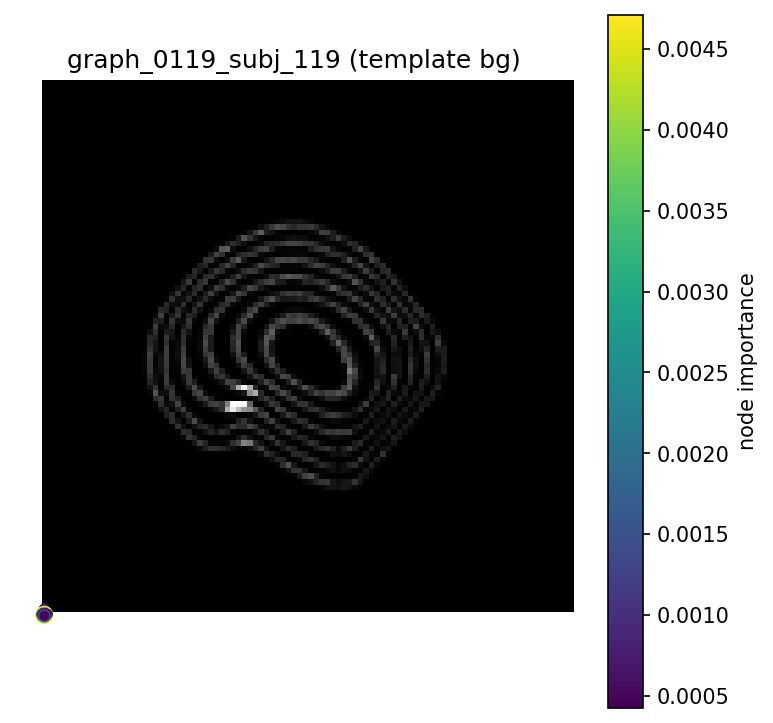

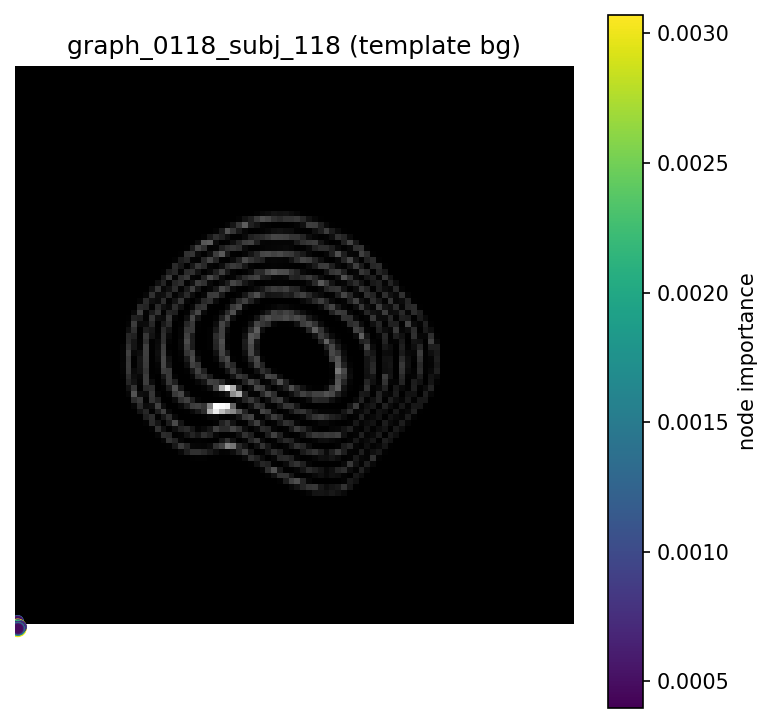

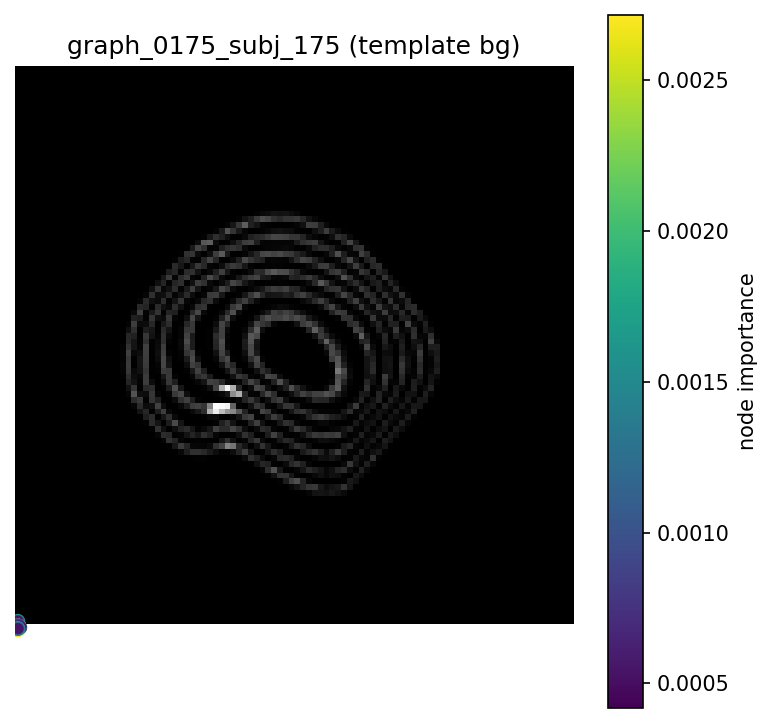

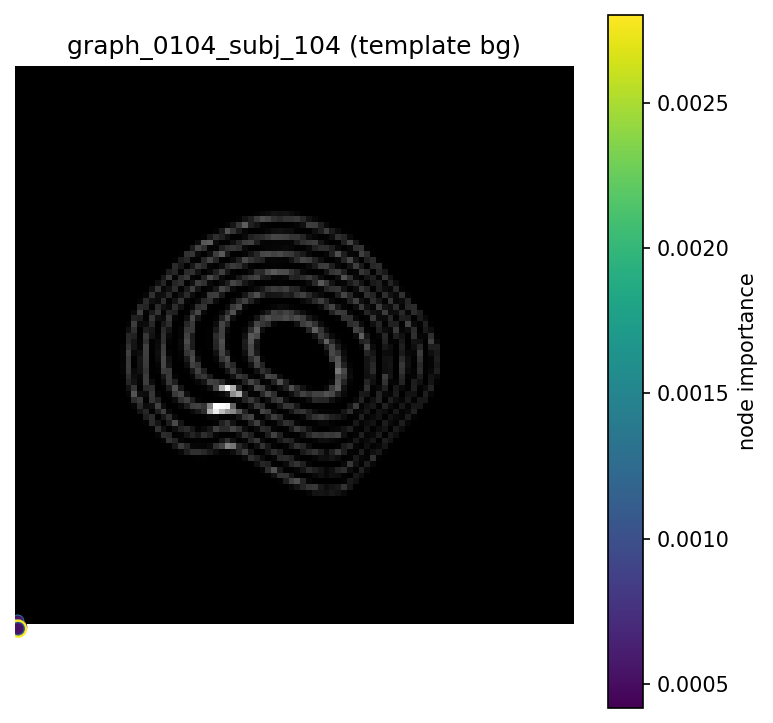

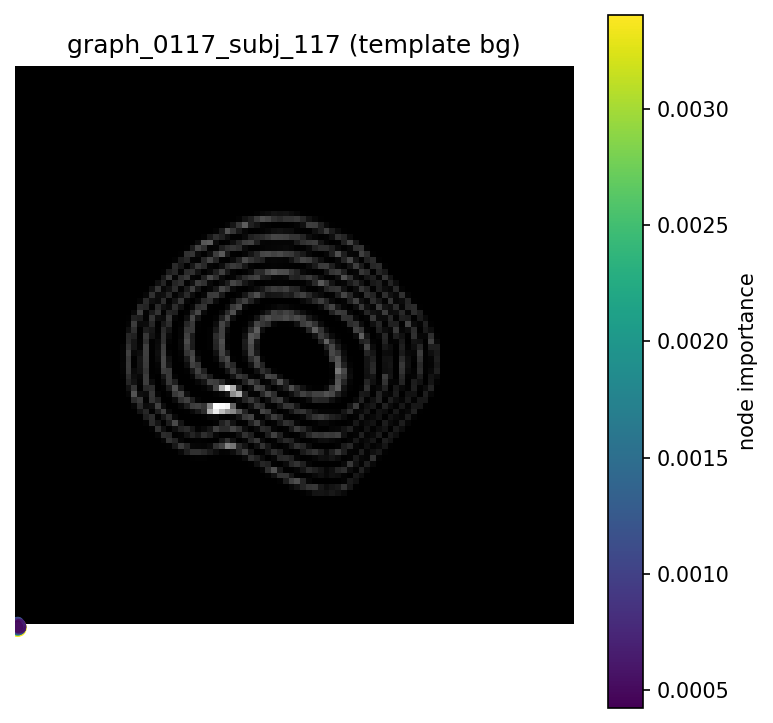

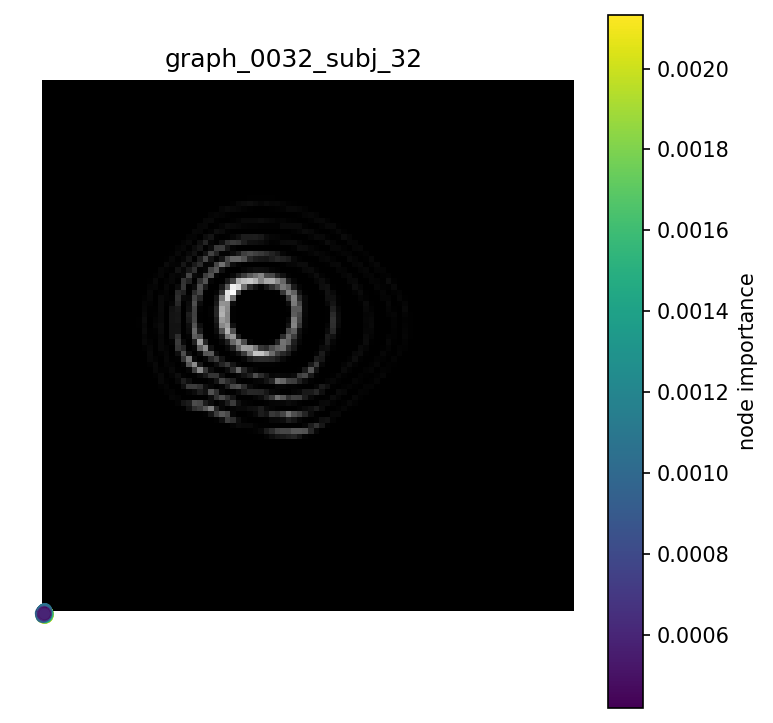

In [ ]:
# Create overlays for reps using subject NIfTI when available, otherwise use a template NIfTI.
import os, glob, numpy as np, pandas as pd, nibabel as nib, matplotlib.pyplot as plt
from IPython.display import display, Image

BASE = os.environ.get("BASE", "/content/drive/MyDrive/oasis_project")
OUT_DIR = os.path.join(BASE, "outputs", "figures", "nifti_overlays")
GNN_DIR = os.path.join(BASE, "outputs", "figures", "gnnexplainer")
NPZ_DIR = os.path.join(BASE, "data", "graphs", "npz_graphs")
os.makedirs(OUT_DIR, exist_ok=True)

# load reps
reps_csv = os.path.join(BASE, "outputs", "figures", "cluster_representatives_k4.csv")
reps = pd.read_csv(reps_csv) if os.path.exists(reps_csv) else globals().get("reps")

# find all nifti files and pick the first as template fallback
nifti_list = sorted(set(glob.glob(os.path.join(BASE, "**", "*.nii.gz"), recursive=True) +
                        glob.glob(os.path.join(BASE, "**", "*.nii"), recursive=True)))
template_nifti = nifti_list[0] if nifti_list else None
print("Template NIfTI (fallback):", template_nifti)

def find_subject_nifti(subj):
    # try exact basename contains
    for p in nifti_list:
        if subj.lower() in os.path.basename(p).lower():
            return p
    # numeric id fallback
    import re
    ids = re.findall(r'\d+', subj)
    for id_ in ids:
        # try zfilled variants
        for t in (id_, id_.zfill(3), id_.zfill(4)):
            for p in nifti_list:
                if t in os.path.basename(p):
                    return p
    return None

def load_node_imp(subj):
    # prefer canonical npy
    p = os.path.join(GNN_DIR, f"{subj}_gnnexplainer_node_mask.npy")
    if os.path.exists(p):
        return np.load(p).ravel(), p
    # try CSV fallback
    matches = glob.glob(os.path.join(BASE, "outputs", "figures", f"*{subj}*node*.csv"), recursive=True)
    if matches:
        import pandas as pd
        df = pd.read_csv(matches[0])
        for col in ['importance','value','node_imp','node_importance']:
            if col in df.columns:
                return df[col].to_numpy().ravel(), matches[0]
        if df.shape[1] >= 2:
            return df.iloc[:,1].to_numpy().ravel(), matches[0]
        return df.iloc[:,0].to_numpy().ravel(), matches[0]
    return None, None

def load_pos_clean(subj, n_nodes):
    # prefer pos_clean next to NPZ (we created these)
    cand = os.path.join(NPZ_DIR, f"{subj}_pos_clean.npy")
    if os.path.exists(cand):
        return np.load(cand), cand
    # try other NPZ dirs or labeled folders
    for root in [os.path.join(BASE,"data","graphs","labeled_npz_full"),
                 os.path.join(BASE,"data","graphs","npz_graphs_resave"),
                 NPZ_DIR]:
        p = os.path.join(root, f"{subj}_pos_clean.npy")
        if os.path.exists(p):
            return np.load(p), p
    # last resort: try reading pos from NPZ and unwrap
    pnpz = os.path.join(NPZ_DIR, f"{subj}.npz")
    if os.path.exists(pnpz):
        with np.load(pnpz, allow_pickle=True) as z:
            if 'pos' in z:
                pos = z['pos']
                arr = np.asarray(pos)
                if arr.shape == ():
                    try:
                        arr = np.asarray(pos.item())
                    except:
                        try:
                            arr = np.asarray(pos.tolist())
                        except:
                            arr = None
                if arr is not None:
                    if arr.ndim==1 and arr.size==n_nodes*3:
                        arr = arr.reshape(n_nodes,3)
                    return arr, pnpz
    return None, None

def world_to_voxel(world_coords, nii_img):
    affine = nii_img.affine
    inv_affine = np.linalg.inv(affine)
    homogeneous = np.concatenate([world_coords, np.ones((world_coords.shape[0],1))], axis=1)
    vox = (inv_affine @ homogeneous.T).T[:, :3]
    return vox

def coords_are_voxel(coords, nii_img):
    shape = np.array(nii_img.shape[:3])
    minc, maxc = coords.min(axis=0), coords.max(axis=0)
    if np.all(minc >= -5) and np.all(maxc <= (shape + 5)):
        return True
    if np.any(np.abs(coords) > 50):
        return False
    vs = np.linalg.norm(nii_img.affine[:3,:3], axis=0)
    if np.all((maxc-minc) < 5*vs):
        return True
    return False

created=[]
skipped=[]
for subj in reps['subject_id'].tolist():
    node_imp, src_imp = load_node_imp(subj)
    if node_imp is None:
        print("SKIP (no importance):", subj); skipped.append(subj); continue
    n_nodes = node_imp.size
    pos, src_pos = load_pos_clean(subj, n_nodes)
    if pos is None:
        print("SKIP (no pos):", subj); skipped.append(subj); continue
    # find per-subject nifti; else use template
    subj_nifti = find_subject_nifti(subj)
    used_template = False
    if subj_nifti is None:
        if template_nifti is None:
            print("SKIP (no nifti anywhere):", subj); skipped.append(subj); continue
        subj_nifti = template_nifti
        used_template = True
    nii = nib.load(subj_nifti)
    data = nii.get_fdata()
    pos_arr = np.asarray(pos)
    if pos_arr.ndim == 1 and pos_arr.size == n_nodes*3:
        pos_arr = pos_arr.reshape(n_nodes,3)
    # convert if world coords
    if not coords_are_voxel(pos_arr, nii):
        pos_vox = world_to_voxel(pos_arr, nii)
    else:
        pos_vox = pos_arr
    # pick axial slice at mean z
    slice_idx = int(round(pos_vox[:,2].mean()))
    slice_idx = max(0, min(slice_idx, data.shape[2]-1))
    slice_img = np.rot90(data[:,:,slice_idx])
    xs = pos_vox[:,0]; ys = pos_vox[:,1]
    display_x = ys; display_y = data.shape[0] - xs
    sel = np.abs(pos_vox[:,2] - slice_idx) <= 3
    if sel.sum() == 0:
        sel = np.ones_like(xs, dtype=bool)
    vals = node_imp[sel]
    dx = display_x[sel]; dy = display_y[sel]
    vmax = float(vals.max()) if vals.size else 1.0
    sizes = 60.0 * (vals / (vmax + 1e-9) + 0.02)
    plt.figure(figsize=(6,6))
    plt.imshow(slice_img, cmap='gray', interpolation='nearest')
    sc = plt.scatter(dx, dy, s=sizes, c=vals)
    plt.colorbar(sc, label='node importance')
    title = subj + (" (template bg)" if used_template else "")
    plt.title(title)
    plt.axis('off')
    outp = os.path.join(OUT_DIR, f"{subj}_overlay{'_template' if used_template else ''}.png")
    plt.savefig(outp, dpi=150, bbox_inches='tight')
    plt.close()
    created.append(outp)
    print("Saved overlay:", outp, "| src_imp:", src_imp, "| src_pos:", src_pos, "| bg:", os.path.basename(subj_nifti))

# gallery
html = os.path.join(OUT_DIR, "gallery_template.html")
with open(html,"w") as f:
    f.write("<html><body>\n")
    for p in created:
        f.write(f"<div style='display:inline-block;margin:8px'><img src='{p}' width='300'><div>{os.path.basename(p)}</div></div>\n")
    f.write("</body></html>")
print("\nDone — overlays created:", len(created), "skipped:", len(skipped))
print("Gallery:", html)
if created:
    for im in created[:6]:
        display(Image(filename=im, width=420))
